#  S&P 500 Recovery Pattern Analysis: 1998-99 vs 2025-26

## OVERVIEW

####  Objective
Comprehensive comparison of market recovery patterns between the **1998 Crisis** and **2025 Market Drop**, analyzing whether historical patterns can predict future recovery trajectories.

####  Comparison Periods
- **Historical Benchmark**: 1998-1999 Crisis Recovery (24 months)
- **Current Analysis**: 2025-2026 Market Drop Recovery (actual data + projections)

In [1]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

# Configuration
warnings.filterwarnings('ignore')
RANDOM_SEED = 3407
np.random.seed(RANDOM_SEED)

# Pandas display settings
pd.set_option('display.precision', 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Plotting configuration
sns.set_style('whitegrid')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7.7)
plt.rcParams['font.size'] = 11

print(f"Random seed set to: {RANDOM_SEED}")

Random seed set to: 3407


In [2]:
CRISIS_1998 = '1998-10-08'  # trough date (as intended)
CRISIS_2025 = '2025-04-08'  # trough date (as intended)
MONTHS_TO_ANALYZE = 24
TRADING_DAYS_PER_MONTH = 21
PRIOR_DAYS = 57


print("Fetching S&P 500 data...")
try:
    ticker = yf.Ticker('^GSPC')
    hist = ticker.history(start='1997-01-01', auto_adjust=True, prepost=False)

    if hist.empty:
        raise ValueError("No data retrieved from Yahoo Finance")

    # robust tz handling
    if getattr(hist.index, "tz", None) is not None:
        hist.index = hist.index.tz_localize(None)

    print(f"Data fetched: {hist.index[0]} to {hist.index[-1]}")
    print(f"Total records: {len(hist)}\n")

except Exception as e:
    print(f"Error fetching data: {e}")
    raise

Fetching S&P 500 data...
Data fetched: 1997-01-02 00:00:00 to 2026-01-12 00:00:00
Total records: 7303



In [3]:
# Helper Functions
def _safe_tick_step(n: int, approx_ticks: int = 8) -> int:
    """Avoid step=0 in range(..., step)."""
    if n <= 0:
        return 1
    return max(1, n // approx_ticks)

def _nearest_loc(idx: pd.DatetimeIndex, target_date: str) -> int:
    """Nearest trading-day location ."""
    if len(idx) == 0:
        return 0
    t = pd.to_datetime(target_date)
    loc = idx.get_indexer([t], method="nearest")[0]
    return int(max(0, min(loc, len(idx) - 1)))

def get_period_after_date(df, start_date, months=18, prior_days=37):
    """
    Extract data for specified months after a given date.
    """
    if df is None or len(df) == 0:
        return df.copy()

    start = pd.to_datetime(start_date)
    trading_days = months * TRADING_DAYS_PER_MONTH

    nearest_loc_global = df.index.get_indexer([start], method="nearest")[0]
    nearest_loc_global = int(max(0, min(nearest_loc_global, len(df) - 1)))
    nearest_start_ts = df.index[nearest_loc_global]

    start_loc_global = max(0, nearest_loc_global - prior_days)
    start0 = df.index[start_loc_global]
    print("Analysis Start Date: ", start0)

    total_len = prior_days + trading_days
    period_data = df.iloc[start_loc_global : start_loc_global + total_len].copy()
    return period_data

def add_months_from_start(df, start_date):
    """Add column showing months elapsed from start date."""
    start = pd.to_datetime(start_date)
    df = df.copy()
    days_diff = (df.index - start).days
    df['months_from_start'] = days_diff / 30.44
    return df

def normalize_to_percent(series):
    """Normalize series to percentage change from first valid value."""
    if len(series) == 0:
        return pd.Series(dtype=float)

    first_valid_idx = series.first_valid_index()
    if first_valid_idx is None:
        return pd.Series(dtype=float)

    first_value = series.loc[first_valid_idx]
    if first_value == 0 or pd.isna(first_value):
        return pd.Series(dtype=float)

    return ((series / first_value) - 1) * 100

def calculate_statistics(price_series):
    """Calculate comprehensive statistics for a price series."""
    if price_series is None or len(price_series) == 0:
        return ["N/A"] * 10

    start_price = float(price_series.iloc[0])
    end_price = float(price_series.iloc[-1])
    min_price = float(price_series.min())
    max_price = float(price_series.max())

    total_return = ((end_price / start_price) - 1) * 100 if start_price else 0.0
    max_drawdown_pct = ((min_price / start_price) - 1) * 100 if start_price else 0.0
    max_gain_pct = ((max_price / start_price) - 1) * 100 if start_price else 0.0

    daily_returns = price_series.pct_change().dropna()
    volatility = float(daily_returns.std() * np.sqrt(252) * 100) if len(daily_returns) else np.nan

    return [
        start_price, end_price, min_price, max_price,
        float(total_return), float(max_drawdown_pct), float(max_gain_pct),
        float(price_series.mean()), volatility, int(len(price_series))
    ]

In [4]:
# Extract both periods
period_1998 = get_period_after_date(hist, CRISIS_1998, MONTHS_TO_ANALYZE, PRIOR_DAYS)
period_2025 = get_period_after_date(hist, CRISIS_2025, MONTHS_TO_ANALYZE, PRIOR_DAYS)

if len(period_1998) == 0:
    raise RuntimeError("1998 period extraction returned empty. Check history range and CRISIS_1998.")

print(f"1998 Crisis Period:")
print(f"  Start: {period_1998.index[0]}")
print(f"  End: {period_1998.index[-1]}")
print(f"  Trading days: {len(period_1998)}\n")

print(f"2025 Crisis Period:")
if len(period_2025) > 0:
    print(f"  Start: {period_2025.index[0]}")
    print(f"  End: {period_2025.index[-1]}")
    print(f"  Trading days: {len(period_2025)}")
else:
    print(f"  No data available yet")
print()

crisis_loc_1998 = _nearest_loc(period_1998.index, CRISIS_1998)

Analysis Start Date:  1998-07-20 00:00:00
Analysis Start Date:  2025-01-15 00:00:00
1998 Crisis Period:
  Start: 1998-07-20 00:00:00
  End: 2000-10-05 00:00:00
  Trading days: 561

2025 Crisis Period:
  Start: 2025-01-15 00:00:00
  End: 2026-01-12 00:00:00
  Trading days: 249



In [5]:
# Pad 2025 data
target_length = len(period_1998)
current_length = len(period_2025)

if current_length > 0 and current_length < target_length:
    last_date = period_2025.index[-1]
    business_days_needed = target_length - current_length
    future_dates = pd.bdate_range(start=last_date + timedelta(days=1), periods=business_days_needed)

    padding_df = pd.DataFrame(index=future_dates, columns=period_2025.columns, dtype=float)
    period_2025_padded = pd.concat([period_2025, padding_df])

    print(f"2025 Period after padding:")
    print(f"  Total length: {len(period_2025_padded)}")
    print(f"  Actual data: {current_length}")
    print(f"  Padded (future): {business_days_needed}")
    print(f"  Projected end date: {period_2025_padded.index[-1]}\n")

elif current_length == 0:
    start_date = pd.to_datetime(CRISIS_2025)
    future_dates = pd.bdate_range(start=start_date, periods=target_length)
    period_2025_padded = pd.DataFrame(index=future_dates, columns=period_1998.columns, dtype=float)
    print(f"2025 Period: No actual data available. Created empty projection.\n")

else:
    period_2025_padded = period_2025.iloc[:target_length].copy()
    print(f"2025 Period: Using {len(period_2025_padded)} data points (no padding needed)\n")

actual_mask_2025 = (~period_2025_padded['Close'].isna()) if 'Close' in period_2025_padded.columns else pd.Series(False, index=period_2025_padded.index)
if current_length > 0:
    actual_mask_2025 = pd.Series(False, index=period_2025_padded.index)
    actual_mask_2025.iloc[:current_length] = True

crisis_loc_2025 = _nearest_loc(period_2025_padded.index, CRISIS_2025) if len(period_2025_padded) else 0

period_1998_with_months = add_months_from_start(period_1998, CRISIS_1998)
period_2025_with_months = add_months_from_start(period_2025_padded, CRISIS_2025)

2025 Period after padding:
  Total length: 561
  Actual data: 249
  Padded (future): 312
  Projected end date: 2027-03-24 00:00:00



## VISUALIZATION 1: Absolute Price Comparison with Actual Dates

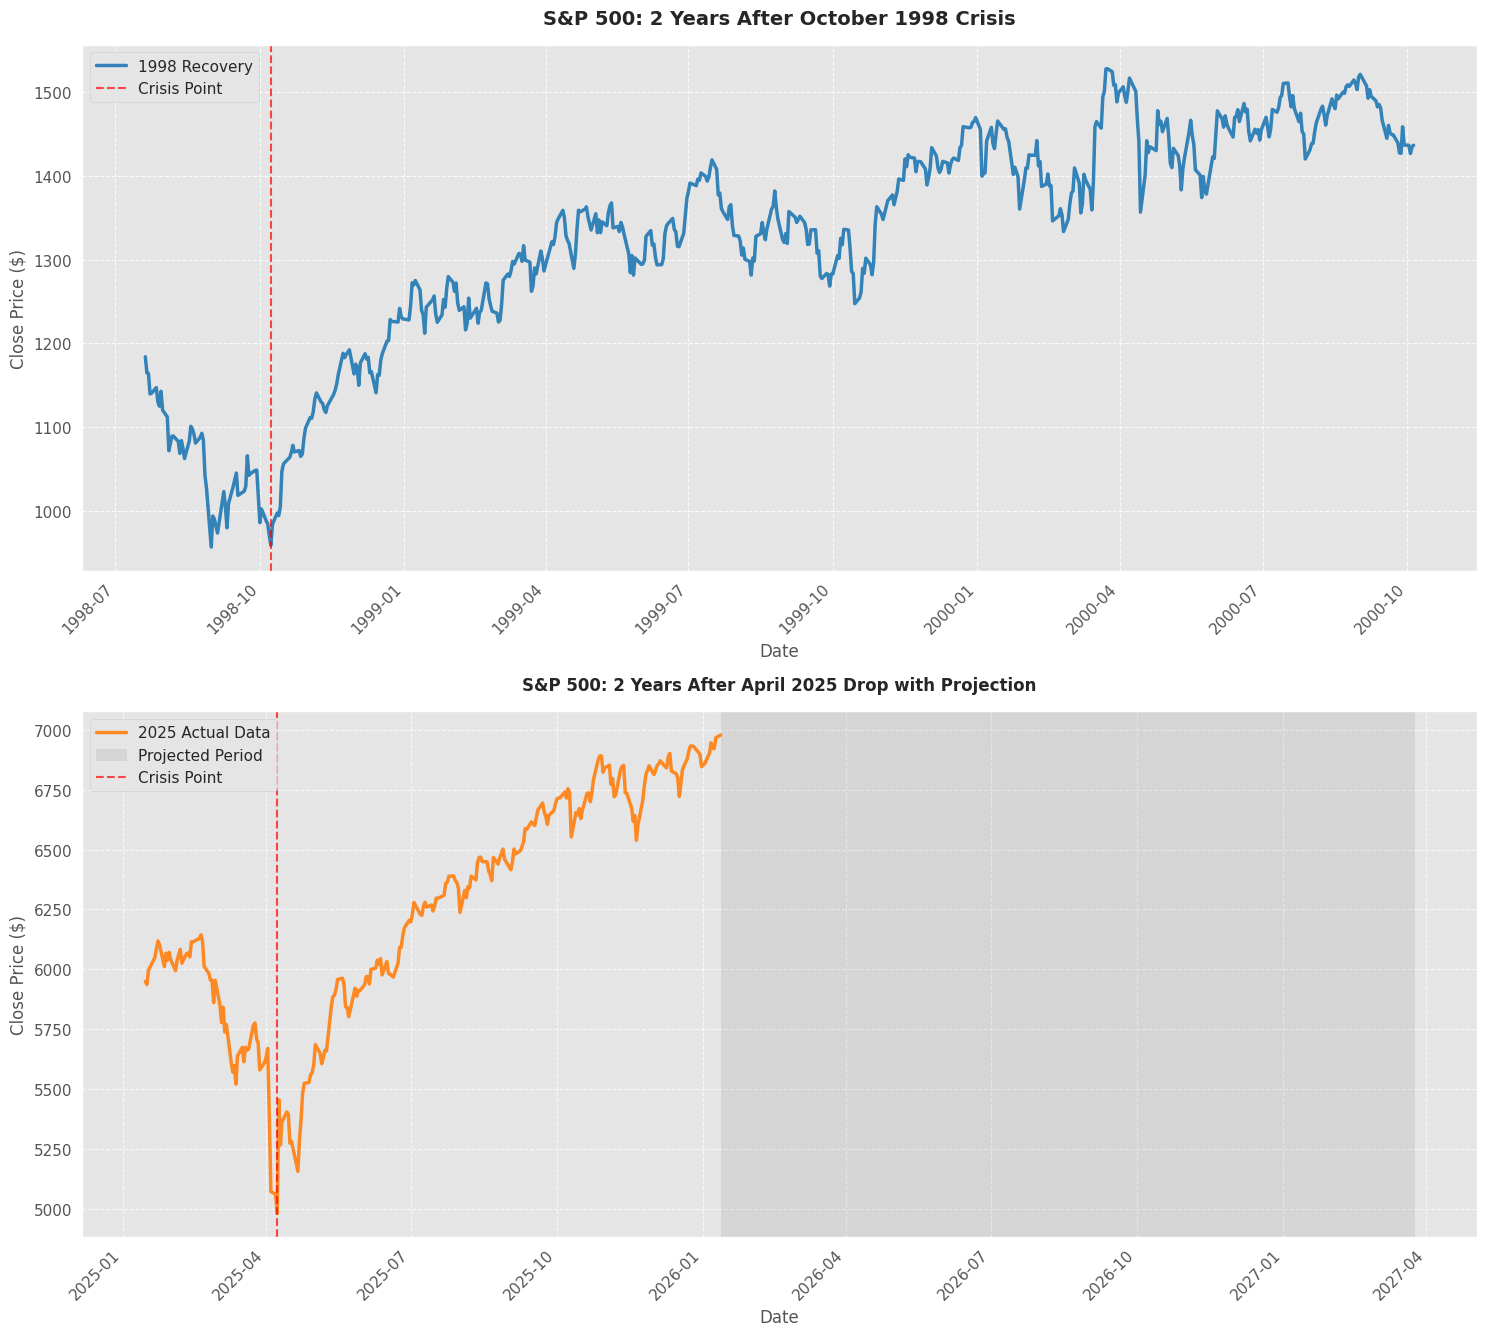

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 13.5))

# Plot 1998 period
ax1.plot(period_1998.index, period_1998['Close'],
         linewidth=2.5, color='#1f77b4', label='1998 Recovery', alpha=0.9)

ax1.axvline(x=period_1998.index[crisis_loc_1998], color='red', linestyle='--',
            linewidth=1.5, alpha=0.7, label='Crisis Point')

ax1.set_title('S&P 500: 2 Years After October 1998 Crisis',
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Close Price ($)', fontsize=12)
ax1.grid(True, alpha=0.8, linestyle='--')
ax1.legend(fontsize=11, loc='best')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2025 period
if current_length > 0:
    ax2.plot(period_2025_padded.index[actual_mask_2025],
             period_2025_padded.loc[actual_mask_2025, 'Close'],
             linewidth=2.5, color='#ff7f0e', label='2025 Actual Data', alpha=0.9)

    if current_length < target_length:
        projected_start = period_2025_padded.index[current_length - 1]
        projected_end = period_2025_padded.index[-1]
        ax2.axvspan(projected_start, projected_end,
                    alpha=0.15, color='gray', label='Projected Period')

    ax2.axvline(x=period_2025_padded.index[crisis_loc_2025], color='red', linestyle='--',
                linewidth=1.5, alpha=0.7, label='Crisis Point')

    title_suffix = 'with Projection' if current_length < target_length else ''
    ax2.set_title(f'S&P 500: 2 Years After April 2025 Drop {title_suffix}',
                  fontsize=12, fontweight='bold', pad=15)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Close Price ($)', fontsize=12)
    ax2.grid(True, alpha=0.7, linestyle='--')
    ax2.legend(fontsize=11, loc='best')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
else:
    ax2.text(0.5, 0.5, 'No data available for 2025 period yet',
             ha='center', va='center', transform=ax2.transAxes,
             fontsize=12, color='gray')
    ax2.set_title('S&P 500: 2 Years After April 2025 Drop (No Data)',
                  fontsize=12, fontweight='bold', pad=15)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Close Price ($)', fontsize=12)

plt.tight_layout()
plt.show()

## VISUALIZATION 2: Normalized Comparison

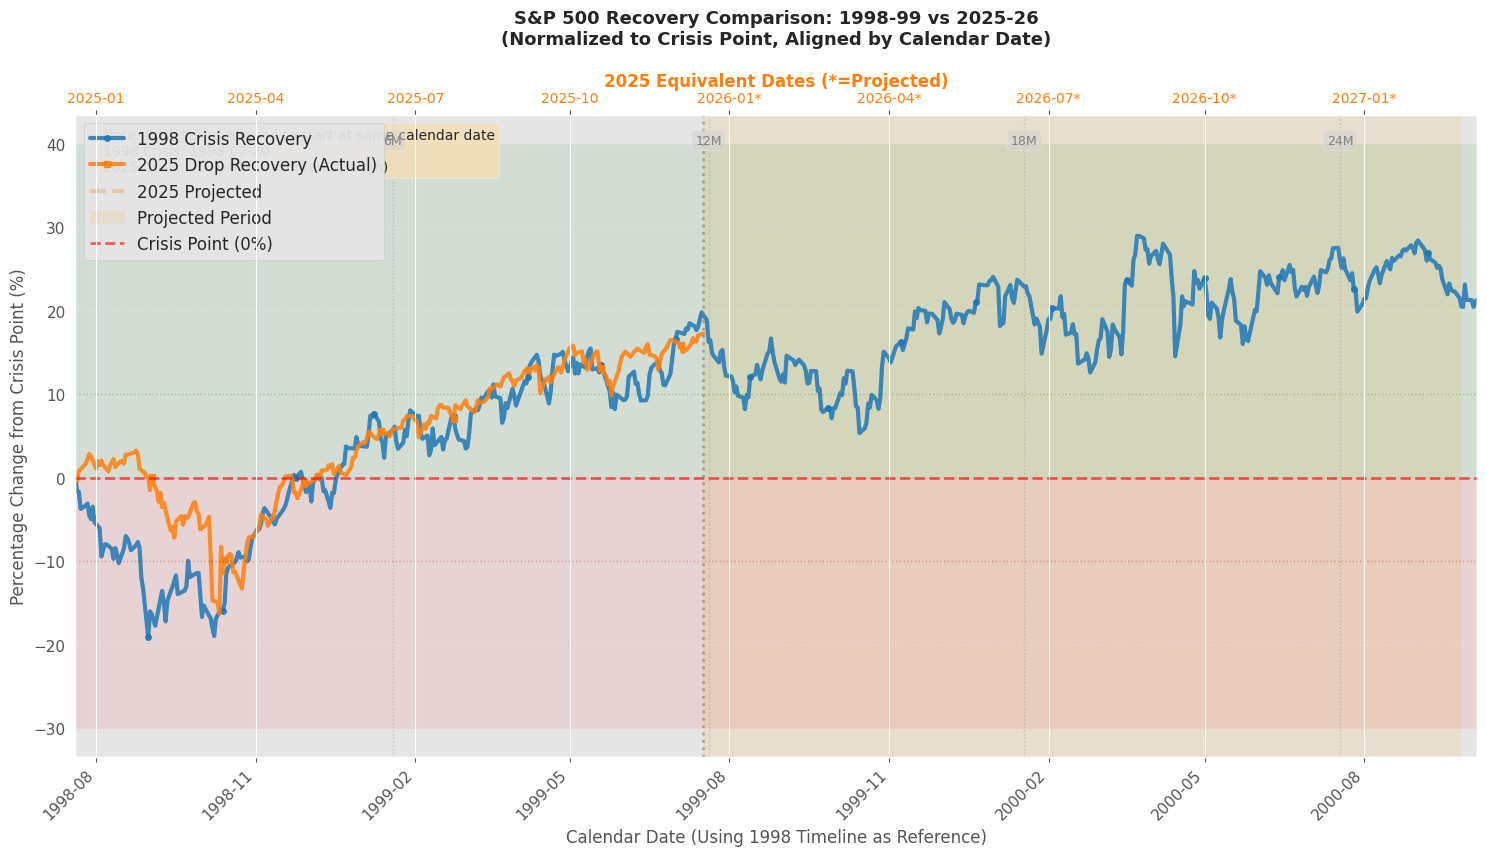

In [7]:
period_1998_norm = normalize_to_percent(period_1998['Close'])
period_2025_norm = normalize_to_percent(period_2025_padded['Close']) if 'Close' in period_2025_padded.columns else pd.Series(dtype=float)

fig, ax = plt.subplots(figsize=(15, 8.7))

if len(period_1998_norm) > 0:
    ax.plot(period_1998.index, period_1998_norm,
            linewidth=3, color='#1f77b4', label='1998 Crisis Recovery',
            alpha=0.85, marker='o', markersize=4, markevery=30)

if current_length > 0 and len(period_2025_norm) > 0:
    date_offset = period_1998.index[0] - period_2025_padded.index[0]
    aligned_2025_dates = period_2025_padded.index + date_offset

    ax.plot(aligned_2025_dates[actual_mask_2025],
            period_2025_norm[actual_mask_2025],
            linewidth=3, color='#ff7f0e', label='2025 Drop Recovery (Actual)',
            alpha=0.85, marker='s', markersize=4, markevery=30)

    if current_length < target_length:
        projected_mask = ~actual_mask_2025
        ax.plot(aligned_2025_dates[projected_mask],
                period_2025_norm[projected_mask],
                linewidth=3, color='#ff7f0e', alpha=0.3,
                linestyle='--', label='2025 Projected')

        projected_start = aligned_2025_dates[actual_mask_2025][-1]
        projected_end = aligned_2025_dates[-1]
        ax.axvspan(projected_start, projected_end,
                   alpha=0.1, color='orange', label='Projected Period')

        ax.axvline(x=projected_start, color='gray', linestyle=':',
                   linewidth=2, alpha=0.6)

# Reference lines
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.6,
           label='Crisis Point (0%)')
ax.axhline(y=10, color='green', linestyle=':', linewidth=1, alpha=0.3)
ax.axhline(y=-10, color='darkred', linestyle=':', linewidth=1, alpha=0.3)

ax.fill_between(period_1998.index, -30, 0, alpha=0.08, color='red')
ax.fill_between(period_1998.index, 0, 40, alpha=0.08, color='green')

ax.set_title('S&P 500 Recovery Comparison: 1998-99 vs 2025-26\n(Normalized to Crisis Point, Aligned by Calendar Date)',
             fontsize=13, fontweight='bold', pad=20)
ax.set_xlabel('Calendar Date (Using 1998 Timeline as Reference)', fontsize=12)
ax.set_ylabel('Percentage Change from Crisis Point (%)', fontsize=12)

ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=12, loc='best', framealpha=0.95)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax.set_xlim(period_1998.index[0], period_1998.index[-1])


if current_length > 0:
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    fig.canvas.draw()

    bottom_tick_locs = ax.get_xticks()                  # matplotlib date numbers
    bottom_tick_dates = mdates.num2date(bottom_tick_locs)
    bottom_tick_dates = [pd.Timestamp(d).tz_localize(None) for d in bottom_tick_dates]

    date_offset = period_1998.index[0] - period_2025_padded.index[0]

    tick_labels_2025 = []
    last_actual_2025_date = period_2025_padded.index[current_length - 1] if current_length > 0 else None

    for d98 in bottom_tick_dates:
        d25 = d98 - date_offset  # convert 1998 tick date -> corresponding 2025 date

        label = pd.Timestamp(d25).strftime('%Y-%m')

        if last_actual_2025_date is None or pd.Timestamp(d25) > pd.Timestamp(last_actual_2025_date):
            label += '*'

        tick_labels_2025.append(label)

    ax_top.set_xticks(bottom_tick_locs)
    ax_top.set_xticklabels(tick_labels_2025, fontsize=10)
    ax_top.set_xlabel('2025 Equivalent Dates (*=Projected)', fontsize=12,
                      color='#ff7f0e', fontweight='bold')
    ax_top.tick_params(axis='x', labelcolor='#ff7f0e')


textstr = 'Note: Both series aligned to start at same calendar date\n'
textstr += f'1998 Crisis: {period_1998.index[0].strftime("%Y-%m-%d")}\n'
if current_length > 0:
    textstr += f'2025 Crisis: {period_2025_padded.index[0].strftime("%Y-%m-%d")} (shifted to align)'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Add milestone markers every 6 months
for month in [6, 12, 18, 24]:
    idx = min(month * TRADING_DAYS_PER_MONTH, len(period_1998) - 1)
    if idx < len(period_1998):
        date = period_1998.index[idx]
        ax.axvline(x=date, color='gray', linestyle=':', linewidth=1, alpha=0.3)
        ax.text(date, ax.get_ylim()[1] * 0.92, f'{month}M',
                ha='center', fontsize=9, color='gray',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.show()

## VISUALIZATION 3: Dual Timeline with Synchronized Axes

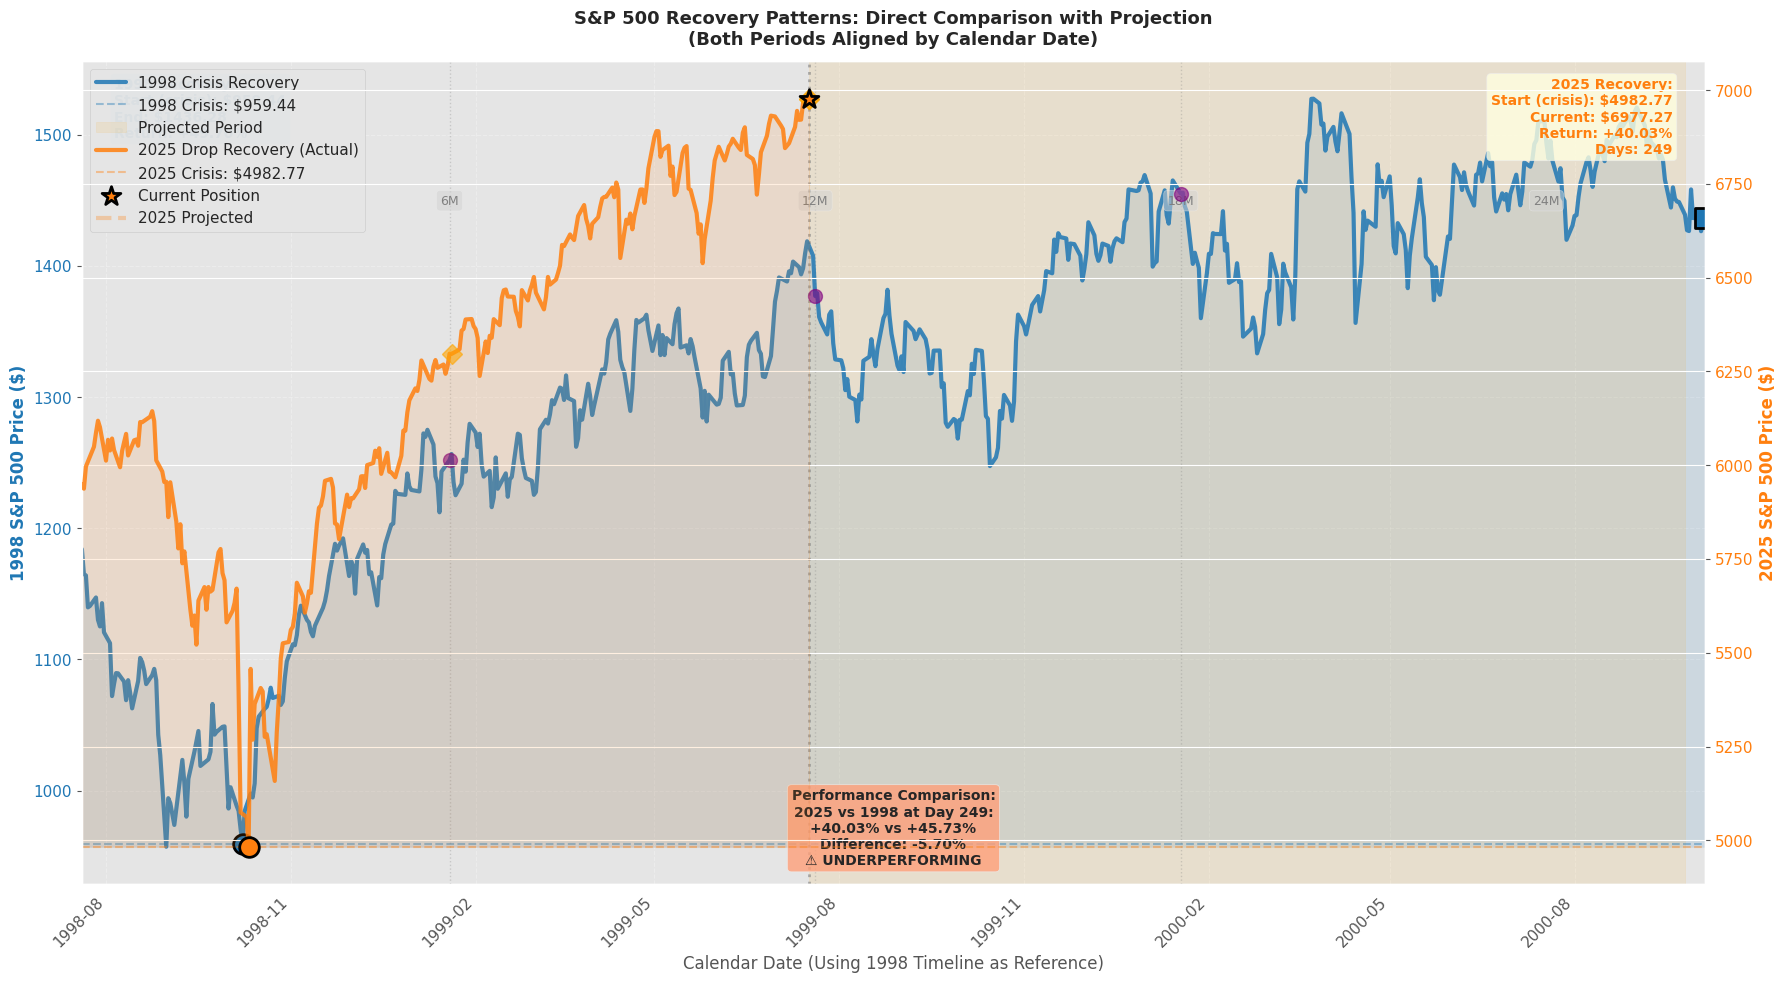

In [8]:
fig, ax1 = plt.subplots(figsize=(18, 10))

# Calculate statistics
min_val_1998, max_val_1998 = period_1998['Close'].min(), period_1998['Close'].max()

# Plot 1998 with actual dates
ax1.plot(period_1998.index, period_1998['Close'],
         linewidth=3, color='#1f77b4', label='1998 Crisis Recovery', alpha=0.85, zorder=3)
ax1.fill_between(period_1998.index, period_1998['Close'],
                 min_val_1998, alpha=0.12, color='#1f77b4')

crisis_price_1998 = period_1998['Close'].iloc[crisis_loc_1998]
recovery_price_1998 = period_1998['Close'].iloc[-1]

ax1.axhline(y=crisis_price_1998, color='#1f77b4', linestyle='--',
            linewidth=1.5, alpha=0.4, label=f'1998 Crisis: ${crisis_price_1998:.2f}')

ax1.scatter([period_1998.index[crisis_loc_1998]], [crisis_price_1998],
            color='#1f77b4', s=200, zorder=5, edgecolors='black', linewidth=2, marker='o')
ax1.scatter([period_1998.index[-1]], [recovery_price_1998],
            color='#1f77b4', s=200, zorder=5, edgecolors='black', linewidth=2, marker='s')

return_1998 = ((recovery_price_1998 / crisis_price_1998) - 1) * 100 if crisis_price_1998 else np.nan

# Add milestone markers for 1998
for month in [6, 12, 18]:
    idx = min(month * TRADING_DAYS_PER_MONTH, len(period_1998) - 1)
    date = period_1998.index[idx]
    price = period_1998['Close'].iloc[idx]
    ax1.axvline(x=date, color='gray', linestyle=':', linewidth=1, alpha=0.3)
    ax1.plot(date, price, 'o', color='purple', markersize=10, zorder=4, alpha=0.6)

# Set up first y-axis
ax1.set_xlabel('Calendar Date (Using 1998 Timeline as Reference)', fontsize=12)
ax1.set_ylabel('1998 S&P 500 Price ($)', fontsize=12, color='#1f77b4', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.grid(True, alpha=0.3, linestyle='--')

# Format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax1.set_xlim(period_1998.index[0], period_1998.index[-1])

ax2 = ax1.twinx()

if current_length > 0:
    # Align 2025 dates to 1998 timeline
    date_offset = period_1998.index[0] - period_2025_padded.index[0]
    aligned_2025_dates = period_2025_padded.index + date_offset

    min_val_2025 = period_2025_padded.loc[actual_mask_2025, 'Close'].min()
    max_val_2025 = period_2025_padded.loc[actual_mask_2025, 'Close'].max()

    # Plot actual 2025 data
    ax2.plot(aligned_2025_dates[actual_mask_2025],
             period_2025_padded.loc[actual_mask_2025, 'Close'],
             linewidth=3, color='#ff7f0e', label='2025 Drop Recovery (Actual)',
             alpha=0.85, zorder=3)
    ax2.fill_between(aligned_2025_dates[actual_mask_2025],
                     period_2025_padded.loc[actual_mask_2025, 'Close'],
                     min_val_2025, alpha=0.12, color='#ff7f0e')

    crisis_price_2025 = period_2025_padded['Close'].iloc[crisis_loc_2025]
    current_price_2025 = period_2025_padded.loc[actual_mask_2025, 'Close'].iloc[-1]

    ax2.axhline(y=crisis_price_2025, color='#ff7f0e', linestyle='--',
                linewidth=1.5, alpha=0.4, label=f'2025 Crisis: ${crisis_price_2025:.2f}')

    ax2.scatter([aligned_2025_dates[crisis_loc_2025]], [crisis_price_2025],
                color='#ff7f0e', s=200, zorder=5, edgecolors='black', linewidth=2, marker='o')
    ax2.scatter([aligned_2025_dates[actual_mask_2025][-1]], [current_price_2025],
                color='#ff7f0e', s=200, zorder=5, edgecolors='black', linewidth=2,
                marker='*', label='Current Position')

    return_2025 = ((current_price_2025 / crisis_price_2025) - 1) * 100 if crisis_price_2025 else np.nan

    # Plot projected continuation if exists
    if current_length < target_length:
        projected_mask = ~actual_mask_2025
        ax2.plot(aligned_2025_dates[projected_mask],
                 period_2025_padded.loc[projected_mask, 'Close'],
                 linewidth=3, color='#ff7f0e', alpha=0.3,
                 linestyle='--', label='2025 Projected', zorder=2)

        projected_start = aligned_2025_dates[actual_mask_2025][-1]
        projected_end = aligned_2025_dates[-1]
        ax1.axvspan(projected_start, projected_end,
                    alpha=0.1, color='orange', label='Projected Period', zorder=1)

        ax1.axvline(x=projected_start, color='gray', linestyle=':',
                    linewidth=2, alpha=0.6, zorder=2)

    for month in [6, 12, 18]:
        idx = min(month * TRADING_DAYS_PER_MONTH, current_length - 1)
        if idx > 0 and idx < len(aligned_2025_dates):
            if actual_mask_2025.iloc[idx]:
                date = aligned_2025_dates[idx]
                price = period_2025_padded.iloc[idx]['Close']
                ax2.plot(date, price, 'D', color='orange', markersize=10, zorder=4, alpha=0.6)

    # Set up second y-axis
    ax2.set_ylabel('2025 S&P 500 Price ($)', fontsize=12, color='#ff7f0e', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='#ff7f0e')

# Add title
title_suffix = ' with Projection' if current_length > 0 and current_length < target_length else ''
fig.suptitle(f'S&P 500 Recovery Patterns: Direct Comparison{title_suffix}\n(Both Periods Aligned by Calendar Date)',
             fontsize=13, fontweight='bold', y=0.98)

lines1, labels1 = ax1.get_legend_handles_labels()
if current_length > 0:
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
               fontsize=11, loc='upper left', framealpha=0.95)
else:
    ax1.legend(lines1, labels1, fontsize=11, loc='upper left', framealpha=0.95)

if current_length > 0:
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    fig.canvas.draw()

    bottom_tick_locs = ax.get_xticks()  
    bottom_tick_dates = mdates.num2date(bottom_tick_locs)
    bottom_tick_dates = [pd.Timestamp(d).tz_localize(None) for d in bottom_tick_dates]

    date_offset = period_1998.index[0] - period_2025_padded.index[0]

    tick_labels_2025 = []
    last_actual_2025_date = period_2025_padded.index[current_length - 1] if current_length > 0 else None

    for d98 in bottom_tick_dates:
        d25 = d98 - date_offset

        projected_flag = (last_actual_2025_date is None) or (pd.Timestamp(d25) > last_actual_2025_date)

        label = pd.Timestamp(d25).strftime('%Y-%m')
        if projected_flag:
            label += '*'
        tick_labels_2025.append(label)

    ax_top.set_xticks(bottom_tick_locs)
    ax_top.set_xticklabels(tick_labels_2025, fontsize=10)
    ax_top.set_xlabel('2025 Equivalent Dates (*=Projected)', fontsize=12,
                      color='#ff7f0e', fontweight='bold')
    ax_top.tick_params(axis='x', labelcolor='#ff7f0e')

if current_length > 0:
    textstr_1998 = f'1998 Recovery:\n'
    textstr_1998 += f'Start (crisis): ${crisis_price_1998:.2f}\n'
    textstr_1998 += f'End: ${recovery_price_1998:.2f}\n'
    textstr_1998 += f'Return: {return_1998:+.2f}%'

    props1 = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    ax1.text(0.02, 0.98, textstr_1998, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=props1, color='#1f77b4', fontweight='bold')

    textstr_2025 = f'2025 Recovery:\n'
    textstr_2025 += f'Start (crisis): ${crisis_price_2025:.2f}\n'
    textstr_2025 += f'Current: ${current_price_2025:.2f}\n'
    textstr_2025 += f'Return: {return_2025:+.2f}%\n'
    textstr_2025 += f'Days: {current_length}'

    props2 = dict(boxstyle='round', facecolor='lightyellow', alpha=0.8)
    ax1.text(0.98, 0.98, textstr_2025, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right', bbox=props2,
             color='#ff7f0e', fontweight='bold')

    equivalent_1998_idx = min(current_length - 1, len(period_1998) - 1)
    equivalent_1998_return = ((period_1998['Close'].iloc[equivalent_1998_idx] / crisis_price_1998) - 1) * 100 if crisis_price_1998 else np.nan
    performance_diff = return_2025 - equivalent_1998_return

    textstr_compare = f'Performance Comparison:\n'
    textstr_compare += f'2025 vs 1998 at Day {current_length}:\n'
    textstr_compare += f'{return_2025:+.2f}% vs {equivalent_1998_return:+.2f}%\n'
    textstr_compare += f'Difference: {performance_diff:+.2f}%\n'
    if performance_diff > 0:
        textstr_compare += '✓ OUTPERFORMING'
        box_color = 'lightgreen'
    else:
        textstr_compare += '⚠ UNDERPERFORMING'
        box_color = 'lightsalmon'

    props3 = dict(boxstyle='round', facecolor=box_color, alpha=0.8)
    ax1.text(0.5, 0.02, textstr_compare, transform=ax1.transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='center', bbox=props3,
             fontweight='bold')

# Add month markers
for month in [6, 12, 18, 24]:
    idx = min(month * TRADING_DAYS_PER_MONTH, len(period_1998) - 1)
    if idx < len(period_1998):
        date = period_1998.index[idx]
        y_pos = ax1.get_ylim()[1] * 0.93
        ax1.text(date, y_pos, f'{month}M',
                 ha='center', fontsize=9, color='gray',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.show()

In [9]:
print("\n" + "=" * 80)
print("VISUALIZATION 3: SINGLE CHART DUAL Y-AXIS ALIGNMENT")
print("=" * 80)
print(f"\nAlignment Strategy:")
print(f"  • Both series start at the same calendar date: {period_1998.index[0].strftime('%Y-%m-%d')}")
print(f"  • 1998 prices shown on LEFT y-axis (blue)")
print(f"  • 2025 prices shown on RIGHT y-axis (orange)")
print(f"  • Direct visual comparison of recovery patterns")

print(f"\n1998 Recovery (Blue):")
print(f"  Date Range: {period_1998.index[0].strftime('%Y-%m-%d')} to {period_1998.index[-1].strftime('%Y-%m-%d')}")
print(f"  Price Range: ${min_val_1998:.2f} - ${max_val_1998:.2f}")
print(f"  Total Return: {return_1998:+.2f}%")

if current_length > 0:
    print(f"\n2025 Recovery (Orange):")
    print(f"  Original Dates: {period_2025_padded.index[0].strftime('%Y-%m-%d')} to {period_2025_padded.index[-1].strftime('%Y-%m-%d')}")
    print(f"  Aligned Dates: {aligned_2025_dates[0].strftime('%Y-%m-%d')} to {aligned_2025_dates[-1].strftime('%Y-%m-%d')}")
    print(f"  Price Range: ${min_val_2025:.2f} - ${max_val_2025:.2f}")
    print(f"  Return to Date: {return_2025:+.2f}%")
    print(f"  Actual Data: {current_length} days (~{current_length/21:.1f} months)")

    print(f"\n Direct Comparison at Day {current_length}:")
    print(f"  • 2025: {return_2025:+.2f}%")
    print(f"  • 1998: {equivalent_1998_return:+.2f}%")
    print(f"  • Difference: {performance_diff:+.2f}% {'✓ Outperforming' if performance_diff > 0 else '⚠ Underperforming'}")

print("=" * 80 + "\n")


VISUALIZATION 3: SINGLE CHART DUAL Y-AXIS ALIGNMENT

Alignment Strategy:
  • Both series start at the same calendar date: 1998-07-20
  • 1998 prices shown on LEFT y-axis (blue)
  • 2025 prices shown on RIGHT y-axis (orange)
  • Direct visual comparison of recovery patterns

1998 Recovery (Blue):
  Date Range: 1998-07-20 to 2000-10-05
  Price Range: $957.28 - $1527.46
  Total Return: +49.70%

2025 Recovery (Orange):
  Original Dates: 2025-01-15 to 2027-03-24
  Aligned Dates: 1998-07-20 to 2000-09-25
  Price Range: $4982.77 - $6977.27
  Return to Date: +40.03%
  Actual Data: 249 days (~11.9 months)

 Direct Comparison at Day 249:
  • 2025: +40.03%
  • 1998: +45.73%
  • Difference: -5.70% ⚠ Underperforming



## VISUALIZATION 4: Overlay Comparison with Dual Y-Axes

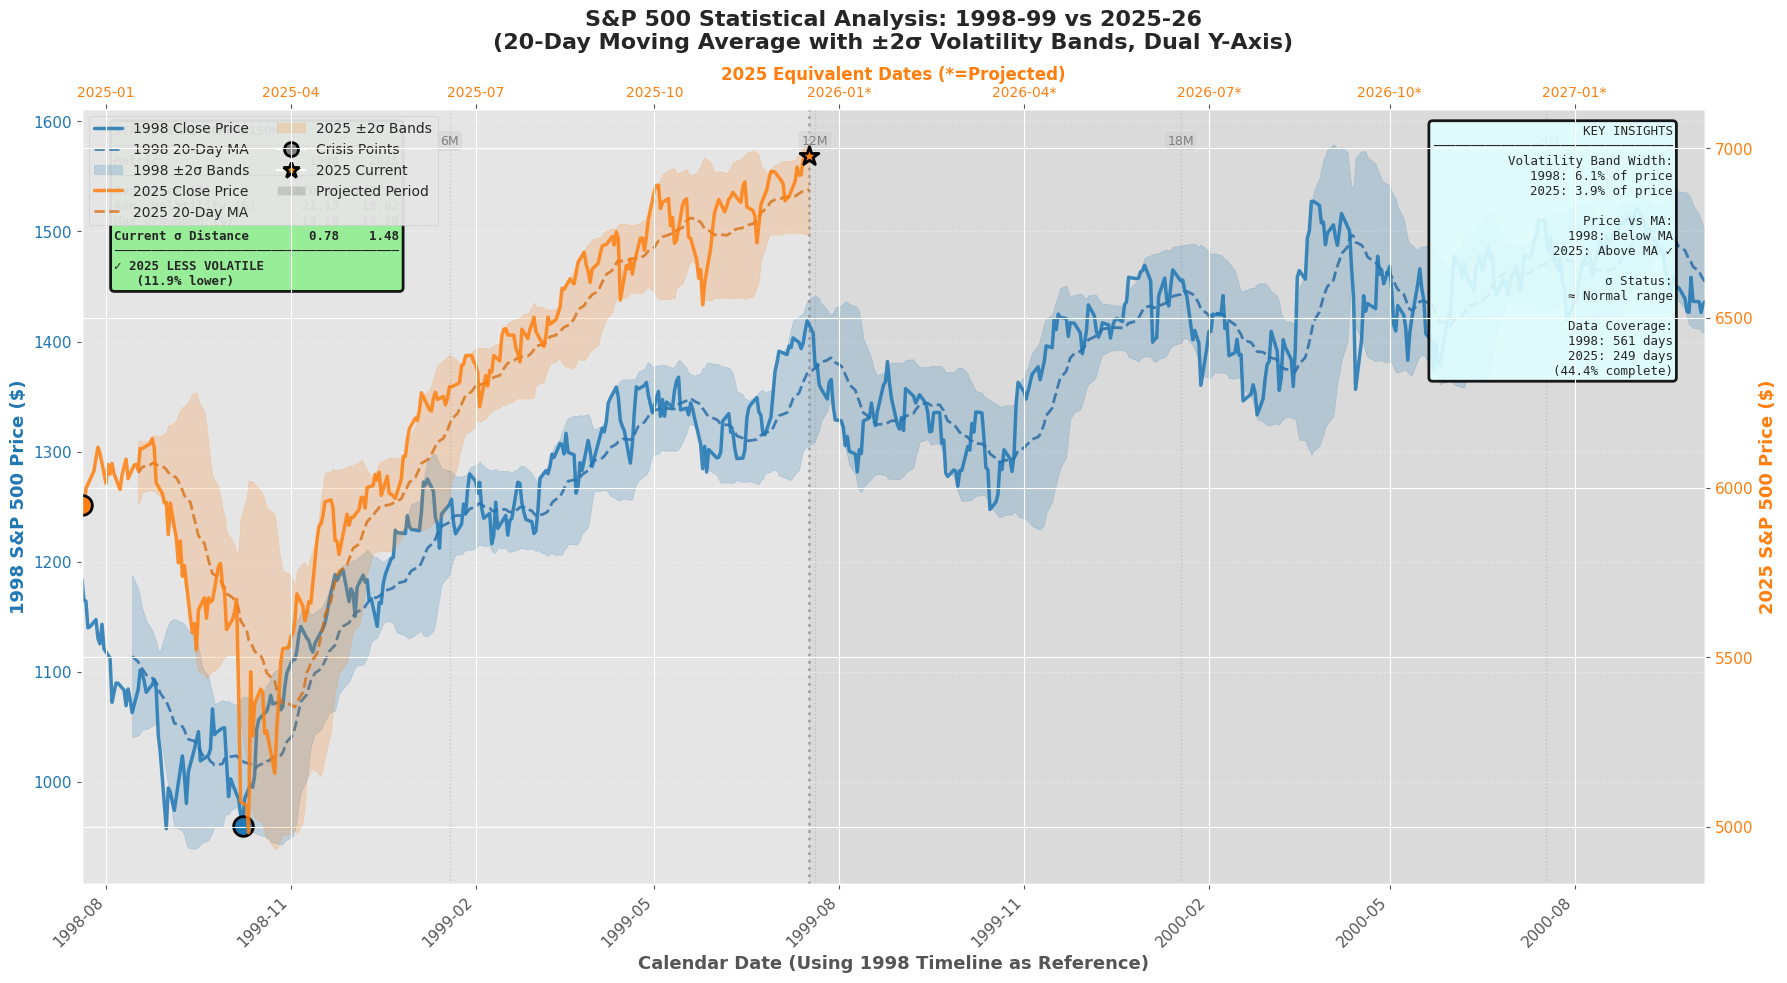

In [10]:
window = 20  # 20-day rolling window
MONTH_INTERVAL_V4 = 3  # 

# 1998 Statistics
rolling_mean_1998 = period_1998['Close'].rolling(window=window).mean()
rolling_std_1998 = period_1998['Close'].rolling(window=window).std()
upper_band_1998 = rolling_mean_1998 + (2 * rolling_std_1998)
lower_band_1998 = rolling_mean_1998 - (2 * rolling_std_1998)

if current_length > 0:
    period_2025_actual = period_2025_padded.loc[actual_mask_2025].copy()

    rolling_mean_2025 = period_2025_actual['Close'].rolling(window=window).mean()
    rolling_std_2025 = period_2025_actual['Close'].rolling(window=window).std()
    upper_band_2025 = rolling_mean_2025 + (2 * rolling_std_2025)
    lower_band_2025 = rolling_mean_2025 - (2 * rolling_std_2025)

    date_offset = period_1998.index[0] - period_2025_actual.index[0]
    aligned_2025_dates = period_2025_actual.index + date_offset

fig, ax1 = plt.subplots(figsize=(18, 10))

ax1.plot(
    period_1998.index, period_1998['Close'],
    linewidth=2.5, color='#1f77b4', label='1998 Close Price', alpha=0.85, zorder=3
)
ax1.plot(
    period_1998.index, rolling_mean_1998,
    linewidth=2, color='#0d5a9e', label='1998 20-Day MA',
    linestyle='--', alpha=0.7, zorder=2
)

valid_1998 = upper_band_1998.notna() & lower_band_1998.notna()
ax1.fill_between(
    period_1998.index[valid_1998],
    upper_band_1998[valid_1998],
    lower_band_1998[valid_1998],
    alpha=0.2, color='#1f77b4', label='1998 ±2σ Bands', zorder=1
)

crisis_price_1998 = period_1998['Close'].iloc[crisis_loc_1998]
ax1.scatter(
    [period_1998.index[crisis_loc_1998]], [crisis_price_1998],
    color='#1f77b4', s=200, zorder=5, edgecolors='black',
    linewidth=2, marker='o'
)

ax1.set_xlabel('Calendar Date (Using 1998 Timeline as Reference)', fontsize=13, fontweight='bold')
ax1.set_ylabel('1998 S&P 500 Price ($)', fontsize=13, color='#1f77b4', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#1f77b4', labelsize=11)
ax1.grid(True, alpha=0.3, linestyle='--', zorder=0)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=MONTH_INTERVAL_V4))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax1.set_xlim(period_1998.index[0], period_1998.index[-1])

ax2 = ax1.twinx()

if current_length > 0:
    ax2.plot(
        aligned_2025_dates, period_2025_actual['Close'],
        linewidth=2.5, color='#ff7f0e', label='2025 Close Price', alpha=0.85, zorder=3
    )
    ax2.plot(
        aligned_2025_dates, rolling_mean_2025,
        linewidth=2, color='#d66400', label='2025 20-Day MA',
        linestyle='--', alpha=0.7, zorder=2
    )

    valid_2025 = upper_band_2025.notna() & lower_band_2025.notna()
    ax2.fill_between(
        aligned_2025_dates[valid_2025],
        upper_band_2025[valid_2025],
        lower_band_2025[valid_2025],
        alpha=0.2, color='#ff7f0e', label='2025 ±2σ Bands', zorder=1
    )

    crisis_price_2025 = (
        period_2025_actual['Close'].iloc[crisis_loc_2025]
        if crisis_loc_2025 < len(period_2025_actual)
        else period_2025_actual['Close'].iloc[0]
    )
    ax2.scatter(
        [aligned_2025_dates[0]], [period_2025_actual['Close'].iloc[0]],
        color='#ff7f0e', s=200, zorder=5, edgecolors='black',
        linewidth=2, marker='o'
    )

    current_price_2025 = period_2025_actual['Close'].iloc[-1]
    ax2.scatter(
        [aligned_2025_dates[-1]], [current_price_2025],
        color='#ff7f0e', s=200, zorder=5, edgecolors='black',
        linewidth=2, marker='*'
    )

    if current_length < target_length:
        last_actual_date = aligned_2025_dates[-1]
        ax1.axvline(x=last_actual_date, color='gray', linestyle=':',
                    linewidth=2, alpha=0.6, zorder=2)

        projected_end = period_1998.index[min(target_length - 1, len(period_1998) - 1)]
        ax1.axvspan(last_actual_date, projected_end,
                    alpha=0.1, color='gray', zorder=0)

    ax2.set_ylabel('2025 S&P 500 Price ($)', fontsize=13, color='#ff7f0e', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='#ff7f0e', labelsize=11)

for month in [6, 12, 18, 24]:
    idx = min(month * TRADING_DAYS_PER_MONTH, len(period_1998) - 1)
    if idx < len(period_1998):
        date = period_1998.index[idx]
        ax1.axvline(x=date, color='gray', linestyle=':', linewidth=1, alpha=0.3, zorder=0)
        ax1.text(
            date, ax1.get_ylim()[1] * 0.98, f'{month}M',
            ha='center', fontsize=9, color='gray',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.6)
        )

fig.suptitle(
    'S&P 500 Statistical Analysis: 1998-99 vs 2025-26\n'
    '(20-Day Moving Average with ±2σ Volatility Bands, Dual Y-Axis)',
    fontsize=16, fontweight='bold', y=0.98
)

lines1, labels1 = ax1.get_legend_handles_labels()
if current_length > 0:
    lines2, labels2 = ax2.get_legend_handles_labels()

    legend_elements = []
    legend_labels = []

    legend_elements.extend(lines1[:3])
    legend_labels.extend(labels1[:3])

    legend_elements.extend(lines2[:3])
    legend_labels.extend(labels2[:3])

    from matplotlib.lines import Line2D
    legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor='gray', markersize=10,
                                  markeredgecolor='black', markeredgewidth=2))
    legend_labels.append('Crisis Points')

    legend_elements.append(Line2D([0], [0], marker='*', color='w',
                                  markerfacecolor='#ff7f0e', markersize=12,
                                  markeredgecolor='black', markeredgewidth=2))
    legend_labels.append('2025 Current')

    if current_length < target_length:
        from matplotlib.patches import Patch
        legend_elements.append(Patch(facecolor='gray', alpha=0.3))
        legend_labels.append('Projected Period')

    ax1.legend(legend_elements, legend_labels,
               fontsize=10, loc='upper left', framealpha=0.95, ncol=2)
else:
    ax1.legend(lines1, labels1, fontsize=10, loc='upper left', framealpha=0.95)

if current_length > 0:
    ax3 = ax1.twiny()
    ax3.set_xlim(ax1.get_xlim())

    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=MONTH_INTERVAL_V4))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.canvas.draw()

    bottom_tick_locs = ax1.get_xticks()  # matplotlib "date numbers"
    bottom_tick_dates = mdates.num2date(bottom_tick_locs)
    bottom_tick_dates = [pd.Timestamp(d).tz_localize(None) for d in bottom_tick_dates]


    date_offset = period_1998.index[0] - period_2025_actual.index[0]
    last_actual_2025 = period_2025_actual.index[-1]

    tick_labels_2025 = []
    for d98 in bottom_tick_dates:
        d25 = pd.Timestamp(d98) - date_offset

        # Label as YYYY-MM; mark projected ticks beyond last actual 2025 date
        lbl = d25.strftime('%Y-%m')
        if d25 > last_actual_2025:
            lbl += '*'
        tick_labels_2025.append(lbl)

    ax3.set_xticks(bottom_tick_locs)
    ax3.set_xticklabels(tick_labels_2025, fontsize=10)
    ax3.set_xlabel('2025 Equivalent Dates (*=Projected)', fontsize=12,
                   color='#ff7f0e', fontweight='bold')
    ax3.tick_params(axis='x', labelcolor='#ff7f0e')

volatility_1998 = period_1998['Close'].pct_change().std() * np.sqrt(252) * 100
avg_price_1998 = period_1998['Close'].mean()
max_dd_1998 = ((period_1998['Close'].cummax() - period_1998['Close']) / period_1998['Close'].cummax() * 100).max()

if current_length > 0:
    volatility_2025 = period_2025_actual['Close'].pct_change().std() * np.sqrt(252) * 100
    avg_price_2025 = period_2025_actual['Close'].mean()
    max_dd_2025 = ((period_2025_actual['Close'].cummax() - period_2025_actual['Close']) / period_2025_actual['Close'].cummax() * 100).max()

# ---- Visualization 4: Statistics/Insights text boxes (continued) ----
if current_length > 0:
    volatility_ratio = (volatility_2025 / volatility_1998) if (volatility_1998 and np.isfinite(volatility_1998)) else np.nan

    stats_text = 'STATISTICAL COMPARISON\n'
    stats_text += '─' * 38 + '\n'
    stats_text += f'{"Metric":<22} {"1998":>7} {"2025":>7}\n'
    stats_text += '─' * 38 + '\n'
    stats_text += f'{"Avg Price ($)":<22} {avg_price_1998:>7.2f} {avg_price_2025:>7.2f}\n'
    stats_text += f'{"Ann. Volatility (%)":<22} {volatility_1998:>7.2f} {volatility_2025:>7.2f}\n'
    stats_text += f'{"Max Drawdown (%)":<22} {max_dd_1998:>7.2f} {max_dd_2025:>7.2f}\n'

    # Calculate current σ distances safely
    sigma_dist_1998 = np.nan
    sigma_dist_2025 = np.nan
    if len(period_1998) >= window and rolling_std_1998.iloc[-1] and np.isfinite(rolling_std_1998.iloc[-1]):
        sigma_dist_1998 = abs(rolling_mean_1998.iloc[-1] - period_1998['Close'].iloc[-1]) / rolling_std_1998.iloc[-1]
    if len(period_2025_actual) >= window and rolling_std_2025.iloc[-1] and np.isfinite(rolling_std_2025.iloc[-1]):
        sigma_dist_2025 = abs(rolling_mean_2025.iloc[-1] - period_2025_actual['Close'].iloc[-1]) / rolling_std_2025.iloc[-1]

    if np.isfinite(sigma_dist_1998) and np.isfinite(sigma_dist_2025):
        stats_text += f'{"Current σ Distance":<22} {sigma_dist_1998:>7.2f} {sigma_dist_2025:>7.2f}\n'

    stats_text += '─' * 38 + '\n'

    if np.isfinite(volatility_ratio):
        if volatility_ratio > 1.1:
            stats_text += '⚠ 2025 MORE VOLATILE\n'
            stats_text += f'   ({(volatility_ratio-1)*100:.1f}% higher)'
            box_color = 'lightsalmon'
        elif volatility_ratio < 0.9:
            stats_text += '✓ 2025 LESS VOLATILE\n'
            stats_text += f'   ({(1-volatility_ratio)*100:.1f}% lower)'
            box_color = 'lightgreen'
        else:
            stats_text += '≈ SIMILAR VOLATILITY\n'
            stats_text += f'   (within 10%)'
            box_color = 'lightyellow'
    else:
        stats_text += 'Volatility ratio unavailable'
        box_color = 'lightgray'

    props = dict(boxstyle='round', facecolor=box_color, alpha=0.9, edgecolor='black', linewidth=2)
    ax1.text(
        0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=9,
        verticalalignment='top', bbox=props, family='monospace',
        fontweight='bold'
    )

    # Key insights box
    insights_text = 'KEY INSIGHTS\n'
    insights_text += '─' * 32 + '\n'

    # Band width comparison (safe)
    recent_band_width_1998 = np.nan
    if rolling_mean_1998.notna().any() and rolling_mean_1998.iloc[-1] and np.isfinite(rolling_mean_1998.iloc[-1]):
        if upper_band_1998.notna().any() and lower_band_1998.notna().any():
            recent_band_width_1998 = (upper_band_1998.iloc[-1] - lower_band_1998.iloc[-1]) / rolling_mean_1998.iloc[-1] * 100

    recent_band_width_2025 = np.nan
    if rolling_mean_2025.notna().any() and rolling_mean_2025.iloc[-1] and np.isfinite(rolling_mean_2025.iloc[-1]):
        if upper_band_2025.notna().any() and lower_band_2025.notna().any():
            recent_band_width_2025 = (upper_band_2025.iloc[-1] - lower_band_2025.iloc[-1]) / rolling_mean_2025.iloc[-1] * 100

    insights_text += 'Volatility Band Width:\n'
    insights_text += f'  1998: {recent_band_width_1998:.1f}% of price\n' if np.isfinite(recent_band_width_1998) else '  1998: N/A\n'
    insights_text += f'  2025: {recent_band_width_2025:.1f}% of price\n\n' if np.isfinite(recent_band_width_2025) else '  2025: N/A\n\n'

    if len(period_1998) >= window and len(period_2025_actual) >= window:
        insights_text += 'Price vs MA:\n'
        insights_text += f'  1998: {"Above MA ✓" if period_1998["Close"].iloc[-1] > rolling_mean_1998.iloc[-1] else "Below MA"}\n'
        insights_text += f'  2025: {"Above MA ✓" if period_2025_actual["Close"].iloc[-1] > rolling_mean_2025.iloc[-1] else "Below MA"}\n'

        insights_text += '\nσ Status:\n'
        if np.isfinite(sigma_dist_2025):
            if sigma_dist_2025 > 1.5:
                insights_text += '  ⚠ High volatility\n'
            elif sigma_dist_2025 < 0.5:
                insights_text += '  ✓ Stabilizing\n'
            else:
                insights_text += '  ≈ Normal range\n'
        else:
            insights_text += '  N/A\n'

    insights_text += '\nData Coverage:\n'
    insights_text += f'  1998: {len(period_1998)} days\n'
    insights_text += f'  2025: {current_length} days\n'
    coverage_pct = (current_length / len(period_1998)) * 100 if len(period_1998) else 0.0
    insights_text += f'  ({coverage_pct:.1f}% complete)'

    props2 = dict(boxstyle='round', facecolor='lightcyan', alpha=0.9, edgecolor='black', linewidth=2)
    ax1.text(
        0.98, 0.98, insights_text, transform=ax1.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right', bbox=props2,
        family='monospace'
    )

plt.tight_layout()
plt.show()

# Statistical Summary

In [11]:

print("=" * 80)
print("STATISTICAL COMPARISON: 1998-99 vs 2025-26 RECOVERY PERIODS")
print("=" * 80)

stats_1998 = calculate_statistics(period_1998['Close'])

if current_length > 0:
    period_2025_actual_close = period_2025_padded.loc[actual_mask_2025, 'Close']
    stats_2025 = calculate_statistics(period_2025_actual_close)
else:
    stats_2025 = ["N/A"] * 10

print(f"\nData Availability:")
print(f"  1998 Period: {len(period_1998)} trading days")
print(f"  2025 Period: {current_length} actual trading days")
if current_length < target_length and current_length > 0:
    print(f"  2025 Projected: {target_length - current_length} future days padded")
print()

stats_df = pd.DataFrame({
    '1998 Recovery': stats_1998,
    '2025 Recovery (Actual)': stats_2025
}, index=[
    'Starting Price ($)', 'Ending Price ($)', 'Minimum Price ($)',
    'Maximum Price ($)', 'Total Return (%)', 'Max Drawdown (%)',
    'Max Gain from Start (%)', 'Average Price ($)',
    'Annualized Volatility (%)', 'Data Points'
])

print(stats_df.to_string())
print("=" * 80)

if current_length > 0 and stats_2025[0] != "N/A":
    print("\nKey Insights:")
    print(f"  • 1998 recovery showed {stats_1998[4]:.2f}% return over {len(period_1998)} days")
    print(f"  • 2025 recovery shows {stats_2025[4]:.2f}% return over {current_length} days so far")

    if stats_1998[4] != "N/A" and stats_2025[4] != "N/A":
        if stats_2025[4] > stats_1998[4]:
            print(f"  • 2025 is OUTPERFORMING 1998 recovery by {stats_2025[4] - stats_1998[4]:.2f}%")
        else:
            print(f"  • 1998 outperformed 2025 recovery by {stats_1998[4] - stats_2025[4]:.2f}%")

    if stats_1998[8] != "N/A" and stats_2025[8] != "N/A":
        if stats_2025[8] > stats_1998[8]:
            print(f"  • 2025 period is more volatile ({stats_2025[8]:.2f}% vs {stats_1998[8]:.2f}%)")
        else:
            print(f"  • 1998 period was more volatile ({stats_1998[8]:.2f}% vs {stats_2025[8]:.2f}%)")

print("=" * 80)

STATISTICAL COMPARISON: 1998-99 vs 2025-26 RECOVERY PERIODS

Data Availability:
  1998 Period: 561 trading days
  2025 Period: 249 actual trading days
  2025 Projected: 312 future days padded

                           1998 Recovery  2025 Recovery (Actual)
Starting Price ($)              1,184.10                5,949.91
Ending Price ($)                1,436.28                6,977.27
Minimum Price ($)                 957.28                4,982.77
Maximum Price ($)               1,527.46                6,977.27
Total Return (%)                   21.30                   17.27
Max Drawdown (%)                  -19.16                  -16.25
Max Gain from Start (%)            29.00                   17.27
Average Price ($)               1,320.94                6,247.34
Annualized Volatility (%)          21.13                   18.62
Data Points                       561.00                  249.00

Key Insights:
  • 1998 recovery showed 21.30% return over 561 days
  • 2025 recovery shows 

## VISUALIZATION 5: Daily Returns Distribution Comparison

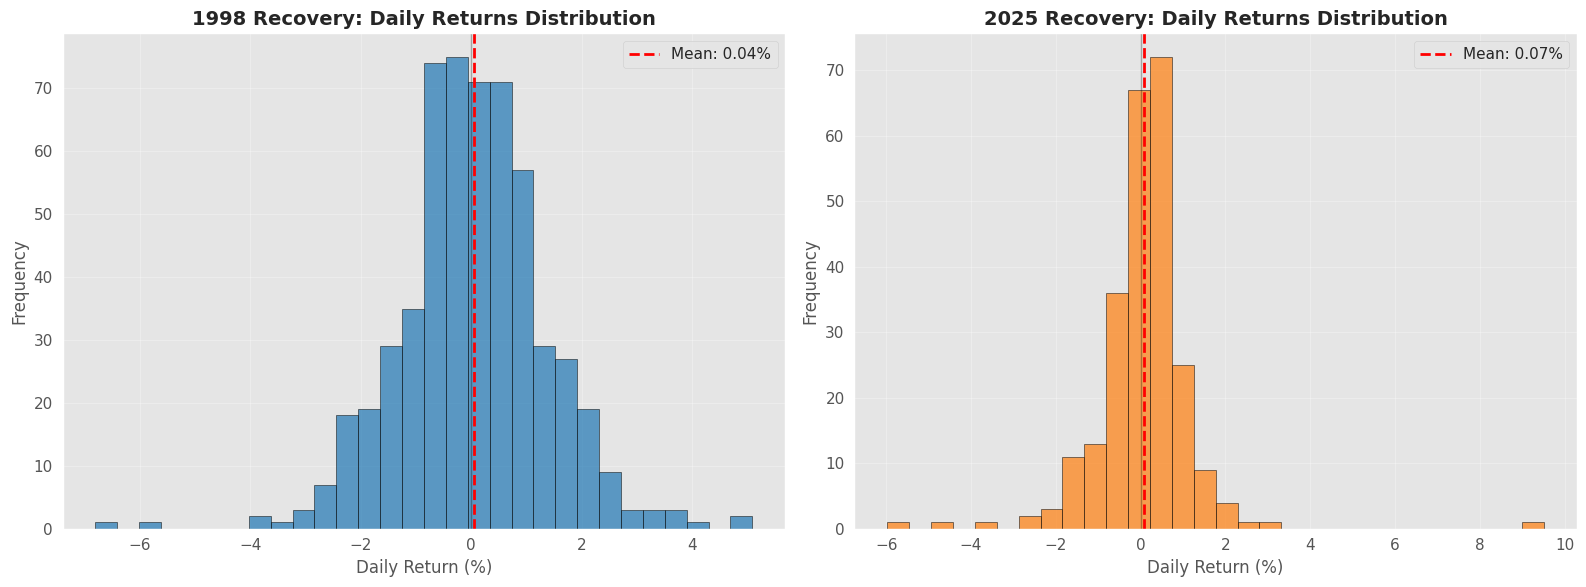

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

returns_1998 = period_1998['Close'].pct_change().dropna() * 100

if current_length > 1:
    returns_2025 = period_2025_padded.loc[actual_mask_2025, 'Close'].pct_change().dropna() * 100
else:
    returns_2025 = pd.Series(dtype=float)

# 1998 histogram
ax1.hist(returns_1998, bins=30, color='#1f77b4', alpha=0.7, edgecolor='black')
ax1.axvline(returns_1998.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {returns_1998.mean():.2f}%')
ax1.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax1.set_title('1998 Recovery: Daily Returns Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Daily Return (%)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2025 histogram
if len(returns_2025) > 0:
    ax2.hist(returns_2025, bins=30, color='#ff7f0e', alpha=0.7, edgecolor='black')
    ax2.axvline(returns_2025.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {returns_2025.mean():.2f}%')
    ax2.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    ax2.set_title('2025 Recovery: Daily Returns Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Daily Return (%)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'Insufficient data for 2025 analysis',
             ha='center', va='center', transform=ax2.transAxes,
             fontsize=14, color='gray')
    ax2.set_title('2025 Recovery: Daily Returns Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## VISUALIZATION 6: Cumulative Returns Comparison

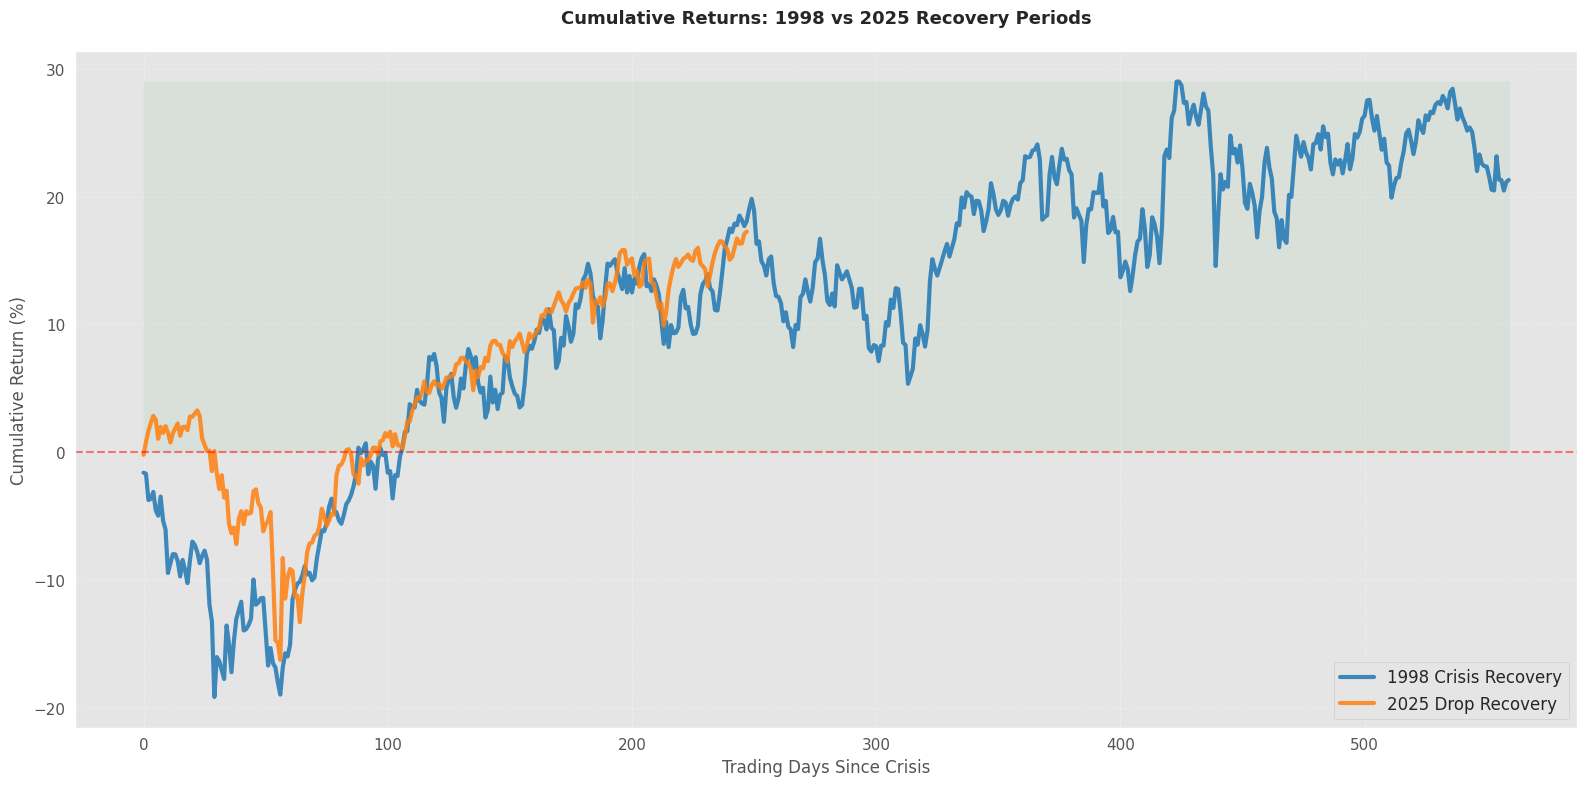

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))

cumulative_1998 = (1 + returns_1998 / 100).cumprod() - 1
cumulative_1998 = cumulative_1998 * 100

ax.plot(range(len(cumulative_1998)), cumulative_1998,
        linewidth=3, color='#1f77b4', label='1998 Crisis Recovery', alpha=0.85)

if len(returns_2025) > 0:
    cumulative_2025 = (1 + returns_2025 / 100).cumprod() - 1
    cumulative_2025 = cumulative_2025 * 100

    ax.plot(range(len(cumulative_2025)), cumulative_2025,
            linewidth=3, color='#ff7f0e', label='2025 Drop Recovery', alpha=0.85)

ax.set_title('Cumulative Returns: 1998 vs 2025 Recovery Periods',
             fontsize=13, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days Since Crisis', fontsize=12)
ax.set_ylabel('Cumulative Return (%)', fontsize=12)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=12, loc='best', framealpha=0.95)

ax.fill_between(range(len(cumulative_1998)), 0, cumulative_1998.max(),
                alpha=0.05, color='green')

plt.tight_layout()
plt.show()

## VISUALIZATION 7: Moving Average Analysis

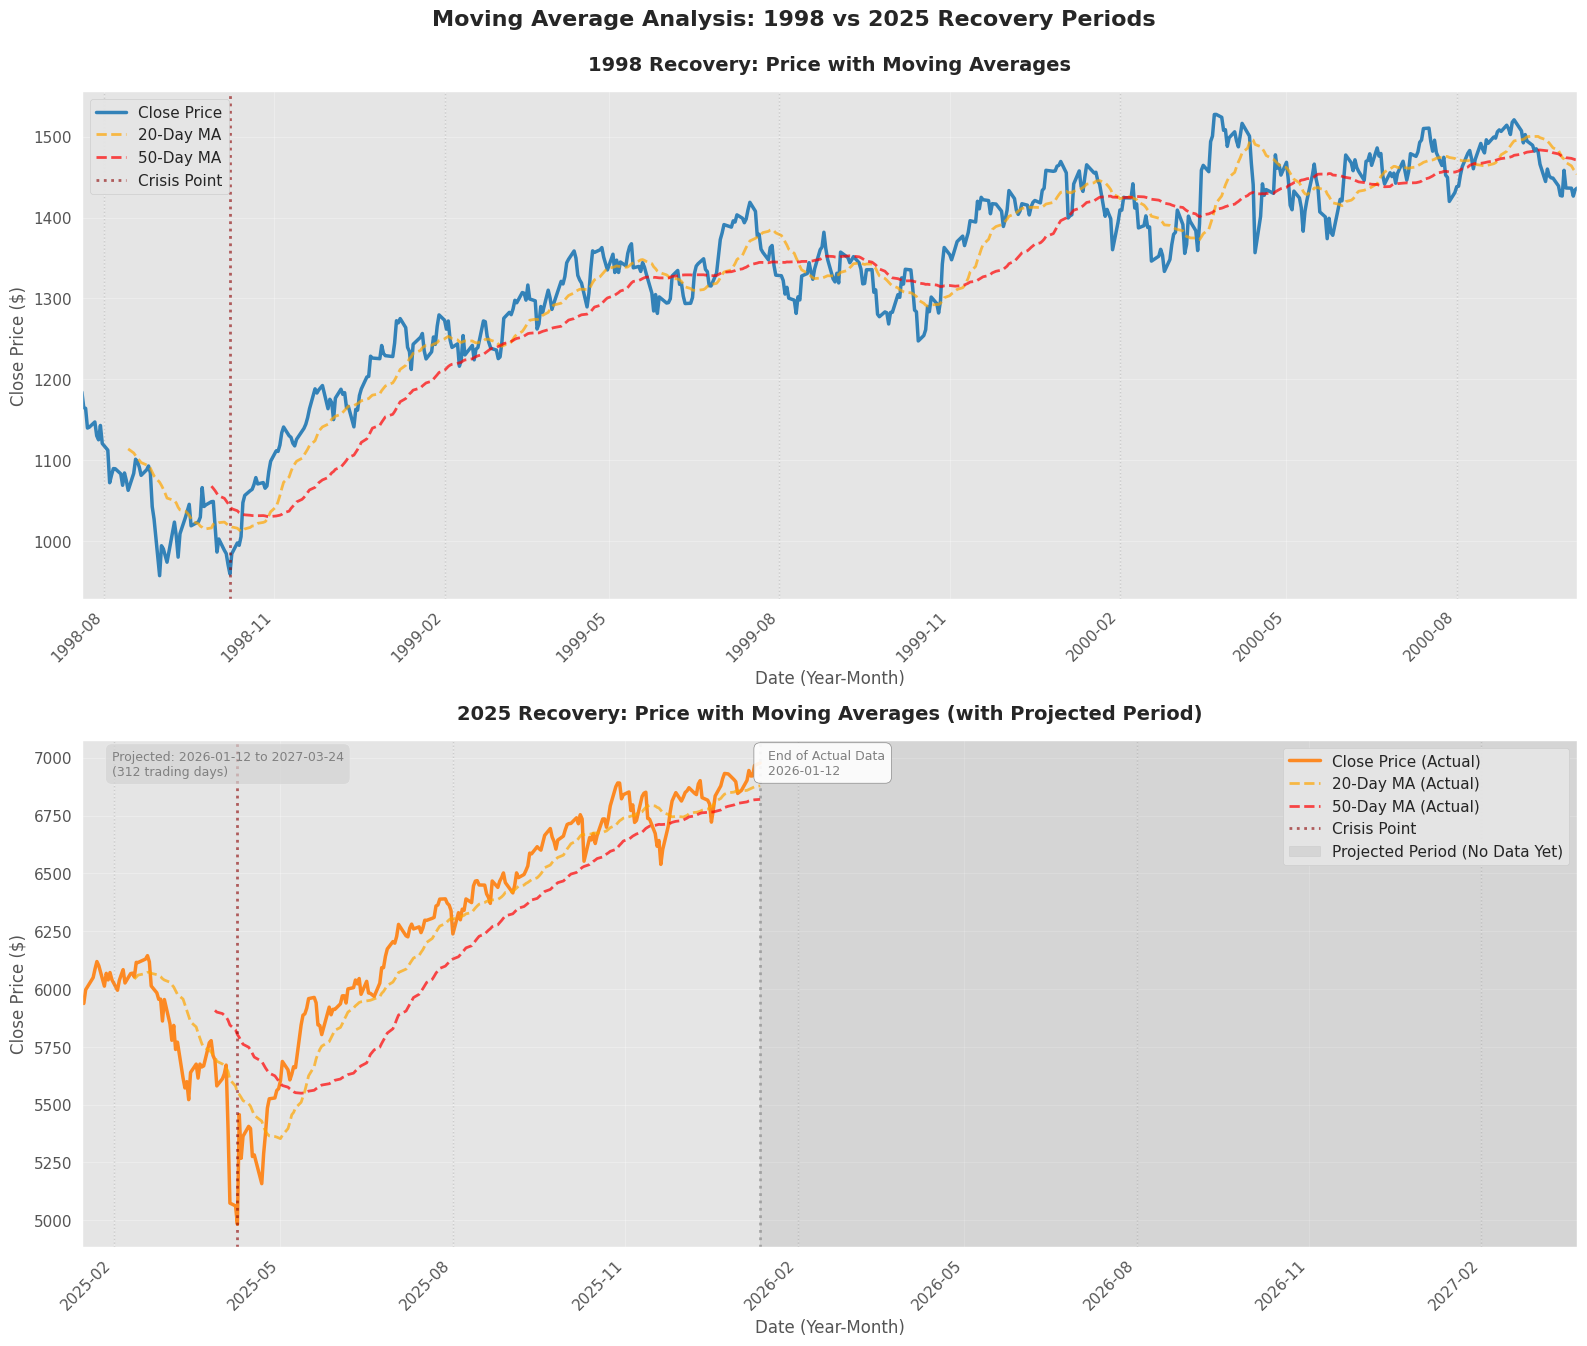

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 13.5))

# Calculate moving averages for 1998
ma_20_1998 = period_1998['Close'].rolling(window=20).mean()
ma_50_1998 = period_1998['Close'].rolling(window=50).mean()

# Plot 1998 with moving averages
ax1.plot(period_1998.index, period_1998['Close'],
         linewidth=2.5, color='#1f77b4', label='Close Price', alpha=0.9)
ax1.plot(period_1998.index, ma_20_1998,
         linewidth=2, color='orange', label='20-Day MA', alpha=0.7, linestyle='--')
ax1.plot(period_1998.index, ma_50_1998,
         linewidth=2, color='red', label='50-Day MA', alpha=0.7, linestyle='--')

ax1.axvline(x=period_1998.index[crisis_loc_1998], color='darkred', linestyle=':',
            linewidth=2, alpha=0.6, label='Crisis Point')

ax1.set_title('1998 Recovery: Price with Moving Averages',
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Date (Year-Month)', fontsize=12)
ax1.set_ylabel('Close Price ($)', fontsize=12)
ax1.legend(fontsize=11, loc='best', framealpha=0.95)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax1.set_xlim(period_1998.index[0], period_1998.index[-1])

month_6_markers = pd.date_range(start=period_1998.index[0],
                                end=period_1998.index[-1], freq='6MS')
for date in month_6_markers:
    if period_1998.index[0] <= date <= period_1998.index[-1]:
        ax1.axvline(x=date, color='gray', linestyle=':', linewidth=1, alpha=0.3)

if current_length > 0:
    series_2025_actual = period_2025_padded.loc[actual_mask_2025, 'Close'].copy()
    ma_20_2025 = series_2025_actual.rolling(window=20).mean()
    ma_50_2025 = series_2025_actual.rolling(window=50).mean()

    # Plot actual data
    ax2.plot(series_2025_actual.index,
             series_2025_actual,
             linewidth=2.5, color='#ff7f0e', label='Close Price (Actual)', alpha=0.9)

    if ma_20_2025.notna().any():
        ax2.plot(series_2025_actual.index[ma_20_2025.notna()],
                 ma_20_2025[ma_20_2025.notna()],
                 linewidth=2, color='orange', label='20-Day MA (Actual)',
                 alpha=0.7, linestyle='--')

    if ma_50_2025.notna().any():
        ax2.plot(series_2025_actual.index[ma_50_2025.notna()],
                 ma_50_2025[ma_50_2025.notna()],
                 linewidth=2, color='red', label='50-Day MA (Actual)',
                 alpha=0.7, linestyle='--')

    ax2.axvline(x=period_2025_padded.index[crisis_loc_2025], color='darkred', linestyle=':',
                linewidth=2, alpha=0.6, label='Crisis Point')

    if current_length < target_length:
        last_actual_date = series_2025_actual.index[-1]
        last_projected_date = period_2025_padded.index[-1]

        ax2.axvspan(last_actual_date, last_projected_date,
                    alpha=0.15, color='gray', label='Projected Period (No Data Yet)')

        ax2.axvline(x=last_actual_date, color='gray', linestyle=':',
                    linewidth=2, alpha=0.6)

        last_actual_price = series_2025_actual.iloc[-1]
        ax2.text(last_actual_date, last_actual_price,
                 f'  End of Actual Data\n  {last_actual_date.strftime("%Y-%m-%d")}',
                 fontsize=9, color='gray', va='center', ha='left',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                           edgecolor='gray', alpha=0.9))

    title_suffix = ' (with Projected Period)' if current_length < target_length else ''
    ax2.set_title(f'2025 Recovery: Price with Moving Averages{title_suffix}',
                  fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Date (Year-Month)', fontsize=12)
    ax2.set_ylabel('Close Price ($)', fontsize=12)
    ax2.legend(fontsize=11, loc='best', framealpha=0.95)
    ax2.grid(True, alpha=0.3)

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax2.set_xlim(period_2025_padded.index[0], period_2025_padded.index[-1])

    # Add vertical markers every 6 months
    month_6_markers_2025 = pd.date_range(start=period_2025_padded.index[0],
                                         end=period_2025_padded.index[-1], freq='6MS')
    for date in month_6_markers_2025:
        if period_2025_padded.index[0] <= date <= period_2025_padded.index[-1]:
            ax2.axvline(x=date, color='gray', linestyle=':', linewidth=1, alpha=0.3)

    if current_length < 50:
        ax2.text(0.98, 0.02,
                 f'Note: Only {current_length} days of actual data\n50-day MA requires ≥50 days',
                 transform=ax2.transAxes, fontsize=9, color='red',
                 ha='right', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

    if current_length < target_length:
        projected_days = target_length - current_length
        ax2.text(0.02, 0.98,
                 f'Projected: {last_actual_date.strftime("%Y-%m-%d")} to {last_projected_date.strftime("%Y-%m-%d")}\n({projected_days} trading days)',
                 transform=ax2.transAxes, fontsize=9, color='gray',
                 ha='left', va='top',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.7))
else:
    start_date = pd.to_datetime(CRISIS_2025)
    end_date = period_2025_padded.index[-1]

    ax2.text(0.5, 0.5,
             f'No 2025 data available yet\n\nProjected Period:\n{start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}\n({target_length} trading days)',
             ha='center', va='center', transform=ax2.transAxes,
             fontsize=12, color='gray',
             bbox=dict(boxstyle='round,pad=1', facecolor='lightgray', alpha=0.3))

    ax2.axvspan(start_date, end_date, alpha=0.15, color='lightgray')

    ax2.set_title('2025 Recovery: Price with Moving Averages (Projected Period)',
                  fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Date (Year-Month)', fontsize=12)
    ax2.set_ylabel('Close Price ($)', fontsize=12)
    ax2.set_xlim(start_date, end_date)

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

fig.suptitle('Moving Average Analysis: 1998 vs 2025 Recovery Periods',
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

# Moving Average Summary

In [15]:
print("\n" + "=" * 80)
print("MOVING AVERAGE ANALYSIS SUMMARY")
print("=" * 80)

print(f"\n1998 Recovery Period:")
print(f"  • Date Range: {period_1998.index[0].strftime('%Y-%m-%d')} to {period_1998.index[-1].strftime('%Y-%m-%d')}")
print(f"  • Duration: {len(period_1998)} trading days ({len(period_1998)/21:.1f} months)")
if len(period_1998) >= 20:
    print(f"  • 20-Day MA: Calculated for {ma_20_1998.notna().sum()} days (from {period_1998.index[19].strftime('%Y-%m-%d')})")
else:
    print("  • 20-Day MA: Not available (period too short)")
if len(period_1998) >= 50:
    print(f"  • 50-Day MA: Calculated for {ma_50_1998.notna().sum()} days (from {period_1998.index[49].strftime('%Y-%m-%d')})")
else:
    print("  • 50-Day MA: Not available (period too short)")

if ma_20_1998.notna().any():
    final_price_1998 = period_1998['Close'].iloc[-1]
    final_ma20_1998 = ma_20_1998.iloc[-1]
    final_ma50_1998 = ma_50_1998.iloc[-1]

    print(f"\n  Final Values ({period_1998.index[-1].strftime('%Y-%m-%d')}):")
    print(f"  • Close Price: ${final_price_1998:.2f}")
    if np.isfinite(final_ma20_1998):
        print(f"  • 20-Day MA: ${final_ma20_1998:.2f} ({((final_price_1998/final_ma20_1998 - 1) * 100):+.2f}%)")
    if not pd.isna(final_ma50_1998) and final_ma50_1998:
        print(f"  • 50-Day MA: ${final_ma50_1998:.2f} ({((final_price_1998/final_ma50_1998 - 1) * 100):+.2f}%)")
        print(f"  • Trend: {'Bullish (20-MA above 50-MA)' if final_ma20_1998 > final_ma50_1998 else 'Bearish (20-MA below 50-MA)'}")

if current_length > 0:
    series_2025_actual = period_2025_padded.loc[actual_mask_2025, 'Close']
    last_actual_date = series_2025_actual.index[-1]

    print(f"\n2025 Recovery Period:")
    print(f"  • Date Range: {period_2025_padded.index[0].strftime('%Y-%m-%d')} to {period_2025_padded.index[-1].strftime('%Y-%m-%d')}")
    print(f"  • Actual Data: {period_2025_padded.index[0].strftime('%Y-%m-%d')} to {last_actual_date.strftime('%Y-%m-%d')}")
    print(f"  • Duration: {current_length} trading days ({current_length/21:.1f} months)")

    if current_length >= 20:
        print(f"  • 20-Day MA: available")
    else:
        print(f"  • 20-Day MA: Not yet available (need {20 - current_length} more days)")

    if current_length >= 50:
        print(f"  • 50-Day MA: available")
    else:
        print(f"  • 50-Day MA: Not yet available (need {50 - current_length} more days)")

    if current_length < target_length:
        projected_days = target_length - current_length
        print(f"\n  • Projected Period: {last_actual_date.strftime('%Y-%m-%d')} to {period_2025_padded.index[-1].strftime('%Y-%m-%d')}")
        print(f"  • Projected Days: {projected_days} trading days ({projected_days/21:.1f} months)")
else:
    print(f"\n2025 Recovery Period:")
    print(f"  • No actual data available yet")
    print(f"  • Projected Range: {period_2025_padded.index[0].strftime('%Y-%m-%d')} to {period_2025_padded.index[-1].strftime('%Y-%m-%d')}")
    print(f"  • Projected Duration: {target_length} trading days ({target_length/21:.1f} months)")

print("=" * 80)


MOVING AVERAGE ANALYSIS SUMMARY

1998 Recovery Period:
  • Date Range: 1998-07-20 to 2000-10-05
  • Duration: 561 trading days (26.7 months)
  • 20-Day MA: Calculated for 542 days (from 1998-08-14)
  • 50-Day MA: Calculated for 512 days (from 1998-09-28)

  Final Values (2000-10-05):
  • Close Price: $1436.28
  • 20-Day MA: $1453.59 (-1.19%)
  • 50-Day MA: $1471.20 (-2.37%)
  • Trend: Bearish (20-MA below 50-MA)

2025 Recovery Period:
  • Date Range: 2025-01-15 to 2027-03-24
  • Actual Data: 2025-01-15 to 2026-01-12
  • Duration: 249 trading days (11.9 months)
  • 20-Day MA: available
  • 50-Day MA: available

  • Projected Period: 2026-01-12 to 2027-03-24
  • Projected Days: 312 trading days (14.9 months)


## VISUALIZATION 8: Volatility Analysis Over Time

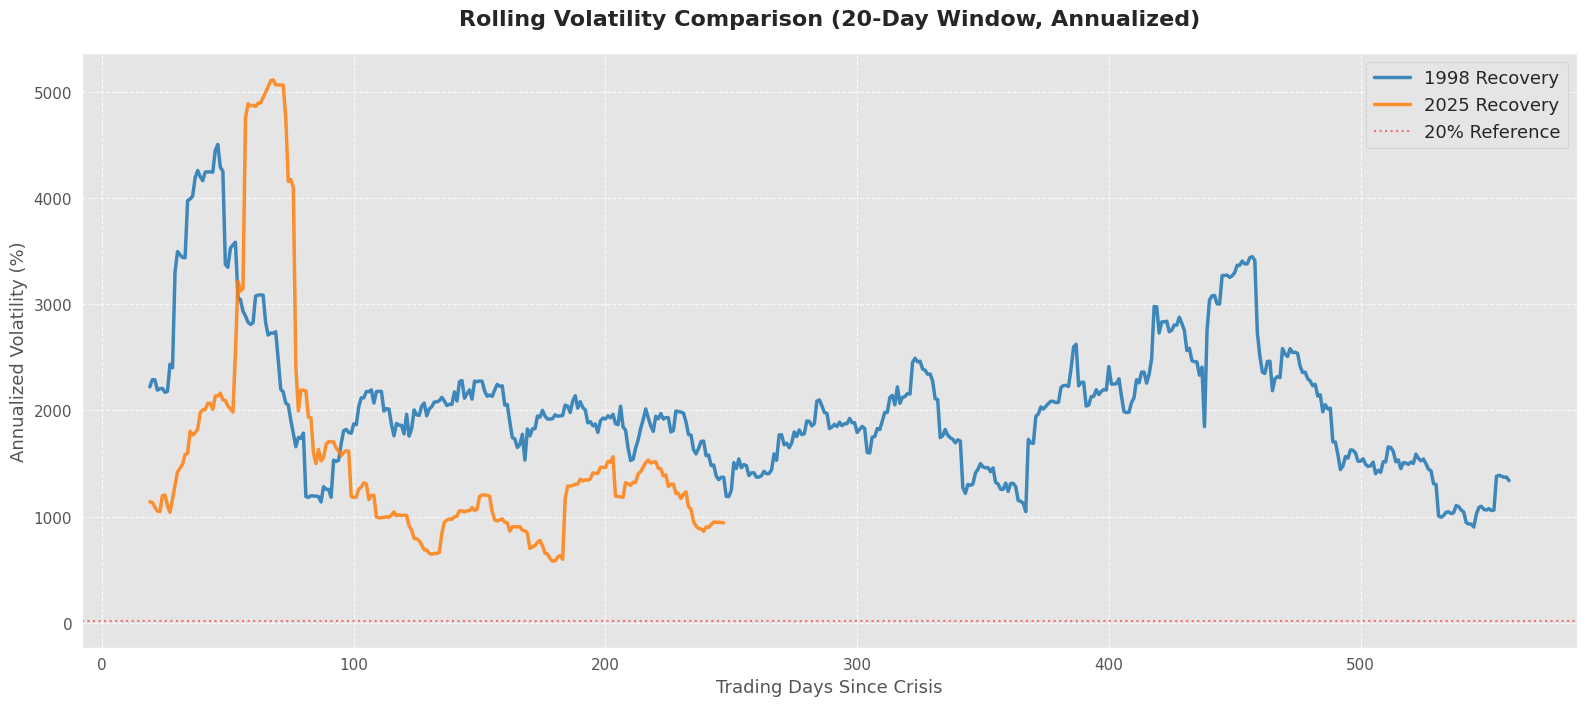

In [16]:
fig, ax = plt.subplots(figsize=(16, 7.2))

window_size = 20
rolling_vol_1998 = returns_1998.rolling(window=window_size).std() * np.sqrt(252) * 100

ax.plot(range(len(rolling_vol_1998)), rolling_vol_1998,
        linewidth=2.5, color='#1f77b4', label='1998 Recovery', alpha=0.85)

if len(returns_2025) > window_size:
    rolling_vol_2025 = returns_2025.rolling(window=window_size).std() * np.sqrt(252) * 100
    ax.plot(range(len(rolling_vol_2025)), rolling_vol_2025,
            linewidth=2.5, color='#ff7f0e', label='2025 Recovery', alpha=0.85)

ax.set_title(f'Rolling Volatility Comparison ({window_size}-Day Window, Annualized)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days Since Crisis', fontsize=13)
ax.set_ylabel('Annualized Volatility (%)', fontsize=13)

ax.axhline(y=20, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label='20% Reference')

ax.legend(fontsize=13, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.8, linestyle='--')

plt.tight_layout()
plt.show()

## VISUALIZATION 9: Risk-Reward Analysis

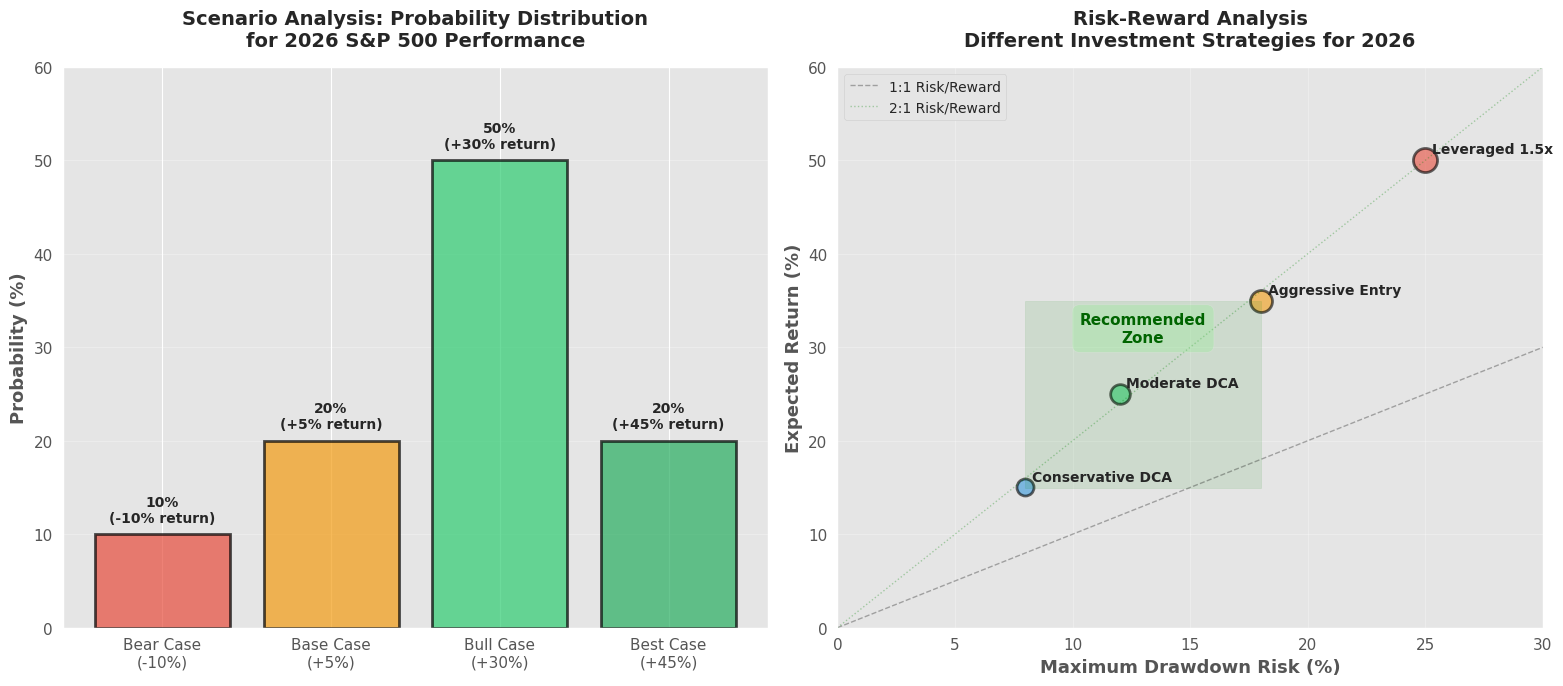

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

scenarios = ['Bear Case\n(-10%)', 'Base Case\n(+5%)', 'Bull Case\n(+30%)', 'Best Case\n(+45%)']
probabilities = [10, 20, 50, 20]
returns_scenarios = [-10, 5, 30, 45]
colors_scenarios = ['#e74c3c', '#f39c12', '#2ecc71', '#27ae60']

bars1 = ax1.bar(scenarios, probabilities, color=colors_scenarios, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Probability (%)', fontsize=13, fontweight='bold')
ax1.set_title('Scenario Analysis: Probability Distribution\nfor 2026 S&P 500 Performance',
              fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 60)

for bar, prob, ret in zip(bars1, probabilities, returns_scenarios):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{prob}%\n({ret:+d}% return)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

investment_strategies = [
    ('Conservative DCA', 8, 15, 150),
    ('Moderate DCA', 12, 25, 200),
    ('Aggressive Entry', 18, 35, 250),
    ('Leveraged 1.5x', 25, 50, 300)
]

for strategy, risk, reward, size in investment_strategies:
    if 'Conservative' in strategy:
        color = '#3498db'
    elif 'Moderate' in strategy:
        color = '#2ecc71'
    elif 'Aggressive' in strategy:
        color = '#f39c12'
    else:
        color = '#e74c3c'

    ax2.scatter(risk, reward, s=size, alpha=0.6, color=color, edgecolors='black', linewidth=2)
    ax2.annotate(strategy, (risk, reward), xytext=(5, 5), textcoords='offset points',
                 fontsize=10, fontweight='bold')

ax2.plot([0, 30], [0, 30], 'k--', alpha=0.3, linewidth=1, label='1:1 Risk/Reward')
ax2.plot([0, 30], [0, 60], 'g:', alpha=0.3, linewidth=1, label='2:1 Risk/Reward')

ax2.set_xlabel('Maximum Drawdown Risk (%)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Expected Return (%)', fontsize=13, fontweight='bold')
ax2.set_title('Risk-Reward Analysis\nDifferent Investment Strategies for 2026',
              fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10, loc='upper left')
ax2.set_xlim(0, 30)
ax2.set_ylim(0, 60)

optimal_zone = plt.Rectangle((8, 15), 10, 20, alpha=0.1, color='green', label='Optimal Zone')
ax2.add_patch(optimal_zone)
ax2.text(13, 32, 'Recommended\nZone', ha='center', va='center',
         fontsize=11, fontweight='bold', color='darkgreen',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.3))

plt.tight_layout()
plt.show()

## VISUALIZATION 10: 2026 Price Projection Chart

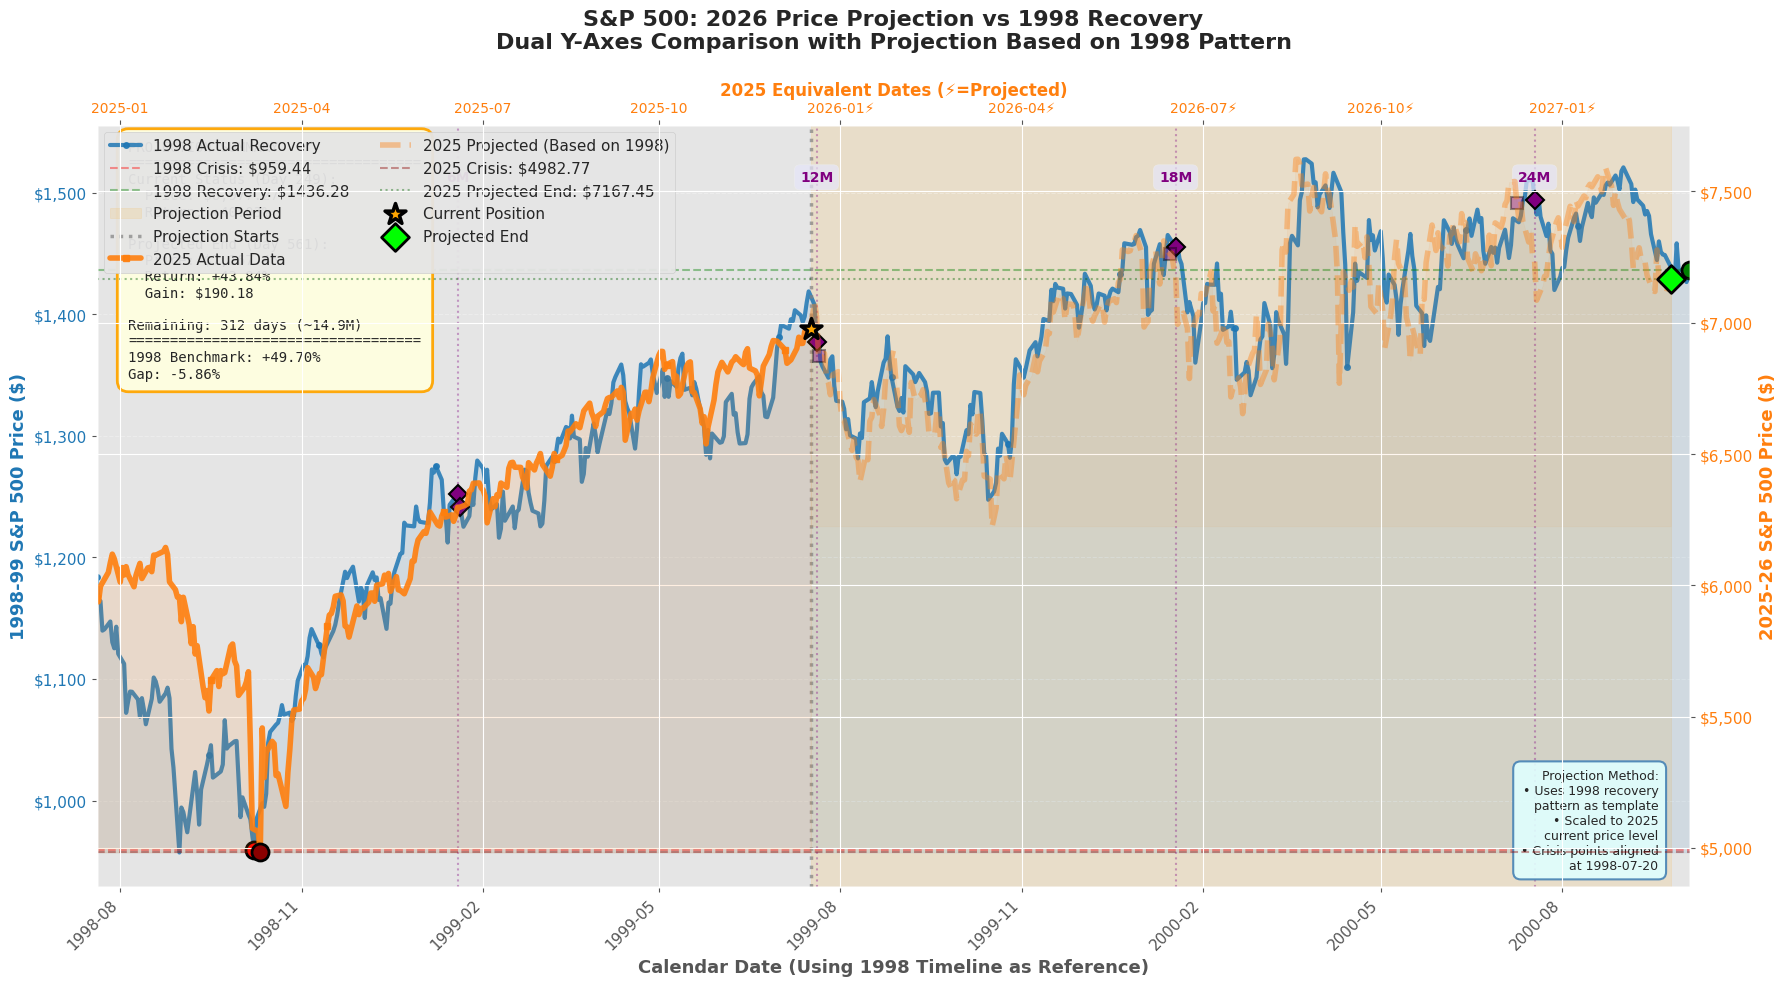

In [18]:
projection_applied = False
if current_length > 0 and current_length < target_length:
    days_to_project = target_length - current_length

    projection_start_idx = min(current_length, len(period_1998) - 1)
    projection_end_idx = min(current_length + days_to_project, len(period_1998))

    reference_1998_prices = period_1998['Close'].iloc[projection_start_idx:projection_end_idx]

    if len(reference_1998_prices) > 0:
        last_actual_price = period_2025_padded.loc[actual_mask_2025, 'Close'].iloc[-1]

        reference_start_idx = max(0, projection_start_idx - 1)
        reference_start = period_1998['Close'].iloc[reference_start_idx]

        if reference_start and np.isfinite(reference_start) and np.isfinite(last_actual_price):
            scale_factor = last_actual_price / reference_start
            projected_prices = reference_1998_prices * scale_factor

            projection_mask = ~actual_mask_2025
            n_to_fill = int(projection_mask.sum())
            n_avail = len(projected_prices)
            n_fill = min(n_to_fill, n_avail)

            if n_fill > 0:
                fill_index = period_2025_padded.index[projection_mask][:n_fill]
                period_2025_padded.loc[fill_index, 'Close'] = projected_prices.values[:n_fill]
                projection_applied = True

fig, ax1 = plt.subplots(figsize=(18, 10))

crisis_price_1998 = period_1998['Close'].iloc[crisis_loc_1998]
recovery_price_1998 = period_1998['Close'].iloc[-1]
return_1998 = ((recovery_price_1998 / crisis_price_1998) - 1) * 100 if crisis_price_1998 else np.nan

ax1.plot(period_1998.index, period_1998['Close'],
         linewidth=3, color='#1f77b4', label='1998 Actual Recovery',
         alpha=0.85, marker='o', markersize=4, markevery=40)
ax1.fill_between(period_1998.index, period_1998['Close'],
                 period_1998['Close'].min(), alpha=0.1, color='#1f77b4')

ax1.axhline(y=crisis_price_1998, color='red', linestyle='--',
            linewidth=1.5, alpha=0.4, label=f'1998 Crisis: ${crisis_price_1998:.2f}')
ax1.axhline(y=recovery_price_1998, color='green', linestyle='--',
            linewidth=1.5, alpha=0.4, label=f'1998 Recovery: ${recovery_price_1998:.2f}')

ax1.scatter([period_1998.index[crisis_loc_1998]], [crisis_price_1998],
            color='red', s=150, zorder=5, edgecolors='black', linewidth=2)
ax1.scatter([period_1998.index[-1]], [recovery_price_1998],
            color='green', s=150, zorder=5, edgecolors='black', linewidth=2)

ax1.set_ylabel('1998-99 S&P 500 Price ($)', fontsize=13, fontweight='bold', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

if current_length > 0:
    date_offset = period_1998.index[0] - period_2025_padded.index[0]
    aligned_2025_dates = period_2025_padded.index + date_offset

    crisis_price_2025 = period_2025_padded['Close'].iloc[crisis_loc_2025]
    current_price_2025 = period_2025_padded.loc[period_2025_padded.index[current_length - 1], 'Close']
    projected_end_price = period_2025_padded['Close'].iloc[-1]

    return_2025_actual = ((current_price_2025 / crisis_price_2025) - 1) * 100 if crisis_price_2025 else np.nan
    return_2025_projected = ((projected_end_price / crisis_price_2025) - 1) * 100 if crisis_price_2025 else np.nan

    ax2 = ax1.twinx()

    ax2.plot(aligned_2025_dates[:current_length],
             period_2025_padded['Close'].iloc[:current_length],
             linewidth=4, color='#ff7f0e', label='2025 Actual Data',
             alpha=0.9, marker='s', markersize=5, markevery=40, zorder=10)

    if current_length < len(period_2025_padded) and projection_applied:
        projection_indices = list(range(current_length - 1, len(period_2025_padded)))
        ax2.plot(aligned_2025_dates[projection_indices],
                 period_2025_padded['Close'].iloc[projection_indices],
                 linewidth=4, color='#ff7f0e', alpha=0.4,
                 linestyle='--', label='2025 Projected (Based on 1998)', zorder=8)

        ax2.fill_between(aligned_2025_dates[:current_length],
                         period_2025_padded['Close'].iloc[:current_length],
                         period_2025_padded['Close'].iloc[:current_length].min(),
                         alpha=0.12, color='#ff7f0e')
        ax2.fill_between(aligned_2025_dates[projection_indices],
                         period_2025_padded['Close'].iloc[projection_indices],
                         period_2025_padded['Close'].iloc[projection_indices].min(),
                         alpha=0.06, color='#ff7f0e')

        projected_start = aligned_2025_dates[current_length - 1]
        projected_end = aligned_2025_dates[-1]
        ax1.axvspan(projected_start, projected_end,
                    alpha=0.12, color='orange', label='Projection Period', zorder=0)
        ax1.axvline(x=projected_start, color='gray', linestyle=':',
                    linewidth=2.5, alpha=0.7, label='Projection Starts')

    ax2.axhline(y=crisis_price_2025, color='darkred', linestyle='--',
                linewidth=1.5, alpha=0.4, label=f'2025 Crisis: ${crisis_price_2025:.2f}')
    ax2.axhline(y=projected_end_price, color='darkgreen', linestyle=':',
                linewidth=1.5, alpha=0.4, label=f'2025 Projected End: ${projected_end_price:.2f}')

    ax2.scatter([aligned_2025_dates[crisis_loc_2025]], [crisis_price_2025],
                color='darkred', s=150, zorder=11, edgecolors='black', linewidth=2)
    ax2.scatter([aligned_2025_dates[current_length - 1]], [current_price_2025],
                color='orange', s=250, zorder=11, edgecolors='black', linewidth=2.5,
                marker='*', label='Current Position')
    ax2.scatter([aligned_2025_dates[-1]], [projected_end_price],
                color='lime', s=200, zorder=11, edgecolors='black', linewidth=2,
                marker='D', label='Projected End')

    ax2.set_ylabel('2025-26 S&P 500 Price ($)', fontsize=13, fontweight='bold', color='#ff7f0e')
    ax2.tick_params(axis='y', labelcolor='#ff7f0e')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
               fontsize=11, loc='upper left', framealpha=0.95, ncol=2)

ax1.set_xlabel('Calendar Date (Using 1998 Timeline as Reference)', fontsize=13, fontweight='bold')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax1.set_xlim(period_1998.index[0], period_1998.index[-1])

for month in [6, 12, 18, 24]:
    idx = min(month * TRADING_DAYS_PER_MONTH, len(period_1998) - 1)
    if idx < len(period_1998):
        date = period_1998.index[idx]
        ax1.axvline(x=date, color='purple', linestyle=':', linewidth=1.5, alpha=0.35)

        y_pos = ax1.get_ylim()[1] * 0.97
        ax1.text(date, y_pos, f'{month}M',
                 ha='center', fontsize=10, color='purple', fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='lavender', alpha=0.7))

        price_1998 = period_1998['Close'].iloc[idx]
        ax1.plot(date, price_1998, 'D', color='purple', markersize=9,
                 markeredgecolor='black', markeredgewidth=1.5, zorder=6)

        if current_length > 0 and idx < len(aligned_2025_dates):
            price_2025 = period_2025_padded.iloc[idx]['Close']
            marker_style = 'D' if idx < current_length else 's'
            alpha_val = 0.9 if idx < current_length else 0.4
            ax2.plot(aligned_2025_dates[idx], price_2025, marker_style,
                     color='purple', markersize=9, alpha=alpha_val,
                     markeredgecolor='black', markeredgewidth=1.5, zorder=6)

if current_length > 0:
    ax3 = ax1.twiny()
    ax3.set_xlim(ax1.get_xlim())

    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    fig.canvas.draw()

    bottom_tick_locs = ax1.get_xticks()                 # matplotlib date numbers
    bottom_tick_dates = mdates.num2date(bottom_tick_locs)
    bottom_tick_dates = [pd.Timestamp(d).tz_localize(None) for d in bottom_tick_dates]

    date_offset = period_1998.index[0] - period_2025_padded.index[0]

    tick_labels_2025 = []
    for d98 in bottom_tick_dates:
        d25 = (d98 - date_offset)

        # Mark projected months (⚡) if beyond last actual 2025 date
        if current_length > 0:
            last_actual_2025_date = period_2025_padded.index[current_length - 1]
            projected_flag = d25 > last_actual_2025_date
        else:
            projected_flag = True

        label = pd.Timestamp(d25).strftime('%Y-%m')
        if projected_flag:
            label += '⚡'
        tick_labels_2025.append(label)

    ax3.set_xticks(bottom_tick_locs)
    ax3.set_xticklabels(tick_labels_2025, fontsize=10)
    ax3.set_xlabel('2025 Equivalent Dates (⚡=Projected)', fontsize=12,
                   color='#ff7f0e', fontweight='bold')
    ax3.tick_params(axis='x', labelcolor='#ff7f0e')


ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

title = 'S&P 500: 2026 Price Projection vs 1998 Recovery\n'
title += 'Dual Y-Axes Comparison with Projection Based on 1998 Pattern'
ax1.set_title(title, fontsize=16, fontweight='bold', pad=55)

if current_length > 0 and current_length < target_length and projection_applied:
    days_remaining = target_length - current_length
    months_remaining = days_remaining / TRADING_DAYS_PER_MONTH

    textstr = f'PROJECTION SUMMARY\n'
    textstr += f'{"=" * 35}\n'
    textstr += f'Current Status (Day {current_length}):\n'
    textstr += f'  Price: ${current_price_2025:,.2f}\n'
    textstr += f'  Return: {return_2025_actual:+.2f}%\n\n'
    textstr += f'Projected End (Day {target_length}):\n'
    textstr += f'  Price: ${projected_end_price:,.2f}\n'
    textstr += f'  Return: {return_2025_projected:+.2f}%\n'
    textstr += f'  Gain: ${projected_end_price - current_price_2025:,.2f}\n\n'
    textstr += f'Remaining: {days_remaining} days (~{months_remaining:.1f}M)\n'
    textstr += f'{"=" * 35}\n'
    textstr += f'1998 Benchmark: {return_1998:+.2f}%\n'
    textstr += f'Gap: {return_2025_projected - return_1998:+.2f}%'

    props = dict(boxstyle='round,pad=0.8', facecolor='lightyellow',
                 edgecolor='orange', linewidth=2, alpha=0.95)
    ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=props, family='monospace')

method_text = 'Projection Method:\n'
method_text += '• Uses 1998 recovery\n'
method_text += '  pattern as template\n'
method_text += '• Scaled to 2025\n'
method_text += '  current price level\n'
method_text += '• Crisis points aligned\n'
method_text += f'  at {period_1998.index[0].strftime("%Y-%m-%d")}'

props2 = dict(boxstyle='round,pad=0.6', facecolor='lightcyan',
              edgecolor='steelblue', linewidth=1.5, alpha=0.9)
ax1.text(0.98, 0.02, method_text, transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='right', bbox=props2)

plt.tight_layout()
plt.show()

In [19]:
# Print detailed projection analysis
print("\n" + "=" * 95)
print("VISUALIZATION 10: 2026 PRICE PROJECTION WITH DUAL-AXIS COMPARISON")
print("=" * 95)

if current_length > 0:
    print(f"\n DATE ALIGNMENT:")
    print(f"  Both series start at: {period_1998.index[0].strftime('%Y-%m-%d')}")
    print(f"  Date offset applied: {(period_1998.index[0] - period_2025_padded.index[0]).days} days")

print(f"\n 1998-99 CRISIS (COMPLETE RECOVERY):")
print(f"  Timeline: {period_1998.index[0].strftime('%Y-%m-%d')} to {period_1998.index[-1].strftime('%Y-%m-%d')}")
print(f"  Crisis Price: ${crisis_price_1998:.2f}")
print(f"  Recovery Price: ${recovery_price_1998:.2f}")
print(f"  Total Return: {return_1998:+.2f}%")
print(f"  Duration: {len(period_1998)} trading days")

if current_length > 0:
    print(f"\n 2025-26 RECOVERY (ACTUAL + PROJECTED):")
    print(f"  Original Timeline: {period_2025_padded.index[0].strftime('%Y-%m-%d')} to {period_2025_padded.index[-1].strftime('%Y-%m-%d')}")
    print(f"\n  ACTUAL DATA (Days 1-{current_length}):")
    print(f"    Crisis Price: ${crisis_price_2025:.2f}")
    print(f"    Current Price: ${current_price_2025:.2f}")
    print(f"    Return to Date: {return_2025_actual:+.2f}%")

    if current_length < target_length and projection_applied:
        print(f"\n  PROJECTED DATA (Days {current_length+1}-{target_length}):")
        print(f"    Projected End Price: ${projected_end_price:.2f}")
        print(f"    Projected Total Return: {return_2025_projected:+.2f}%")
        print(f"    Expected Gain: ${projected_end_price - current_price_2025:,.2f}")
        print(f"    Days Remaining: {target_length - current_length}")
        print(f"    Months Remaining: ~{(target_length - current_length) / TRADING_DAYS_PER_MONTH:.1f}")
    else:
        print("\n  No projection was applied (either complete data or projection could not be computed safely).")

print("\n" + "=" * 95 + "\n")


VISUALIZATION 10: 2026 PRICE PROJECTION WITH DUAL-AXIS COMPARISON

 DATE ALIGNMENT:
  Both series start at: 1998-07-20
  Date offset applied: -9676 days

 1998-99 CRISIS (COMPLETE RECOVERY):
  Timeline: 1998-07-20 to 2000-10-05
  Crisis Price: $959.44
  Recovery Price: $1436.28
  Total Return: +49.70%
  Duration: 561 trading days

 2025-26 RECOVERY (ACTUAL + PROJECTED):
  Original Timeline: 2025-01-15 to 2027-03-24

  ACTUAL DATA (Days 1-249):
    Crisis Price: $4982.77
    Current Price: $6977.27
    Return to Date: +40.03%

  PROJECTED DATA (Days 250-561):
    Projected End Price: $7167.45
    Projected Total Return: +43.84%
    Expected Gain: $190.18
    Days Remaining: 312
    Months Remaining: ~14.9




##  ANALYSIS SUMMARY

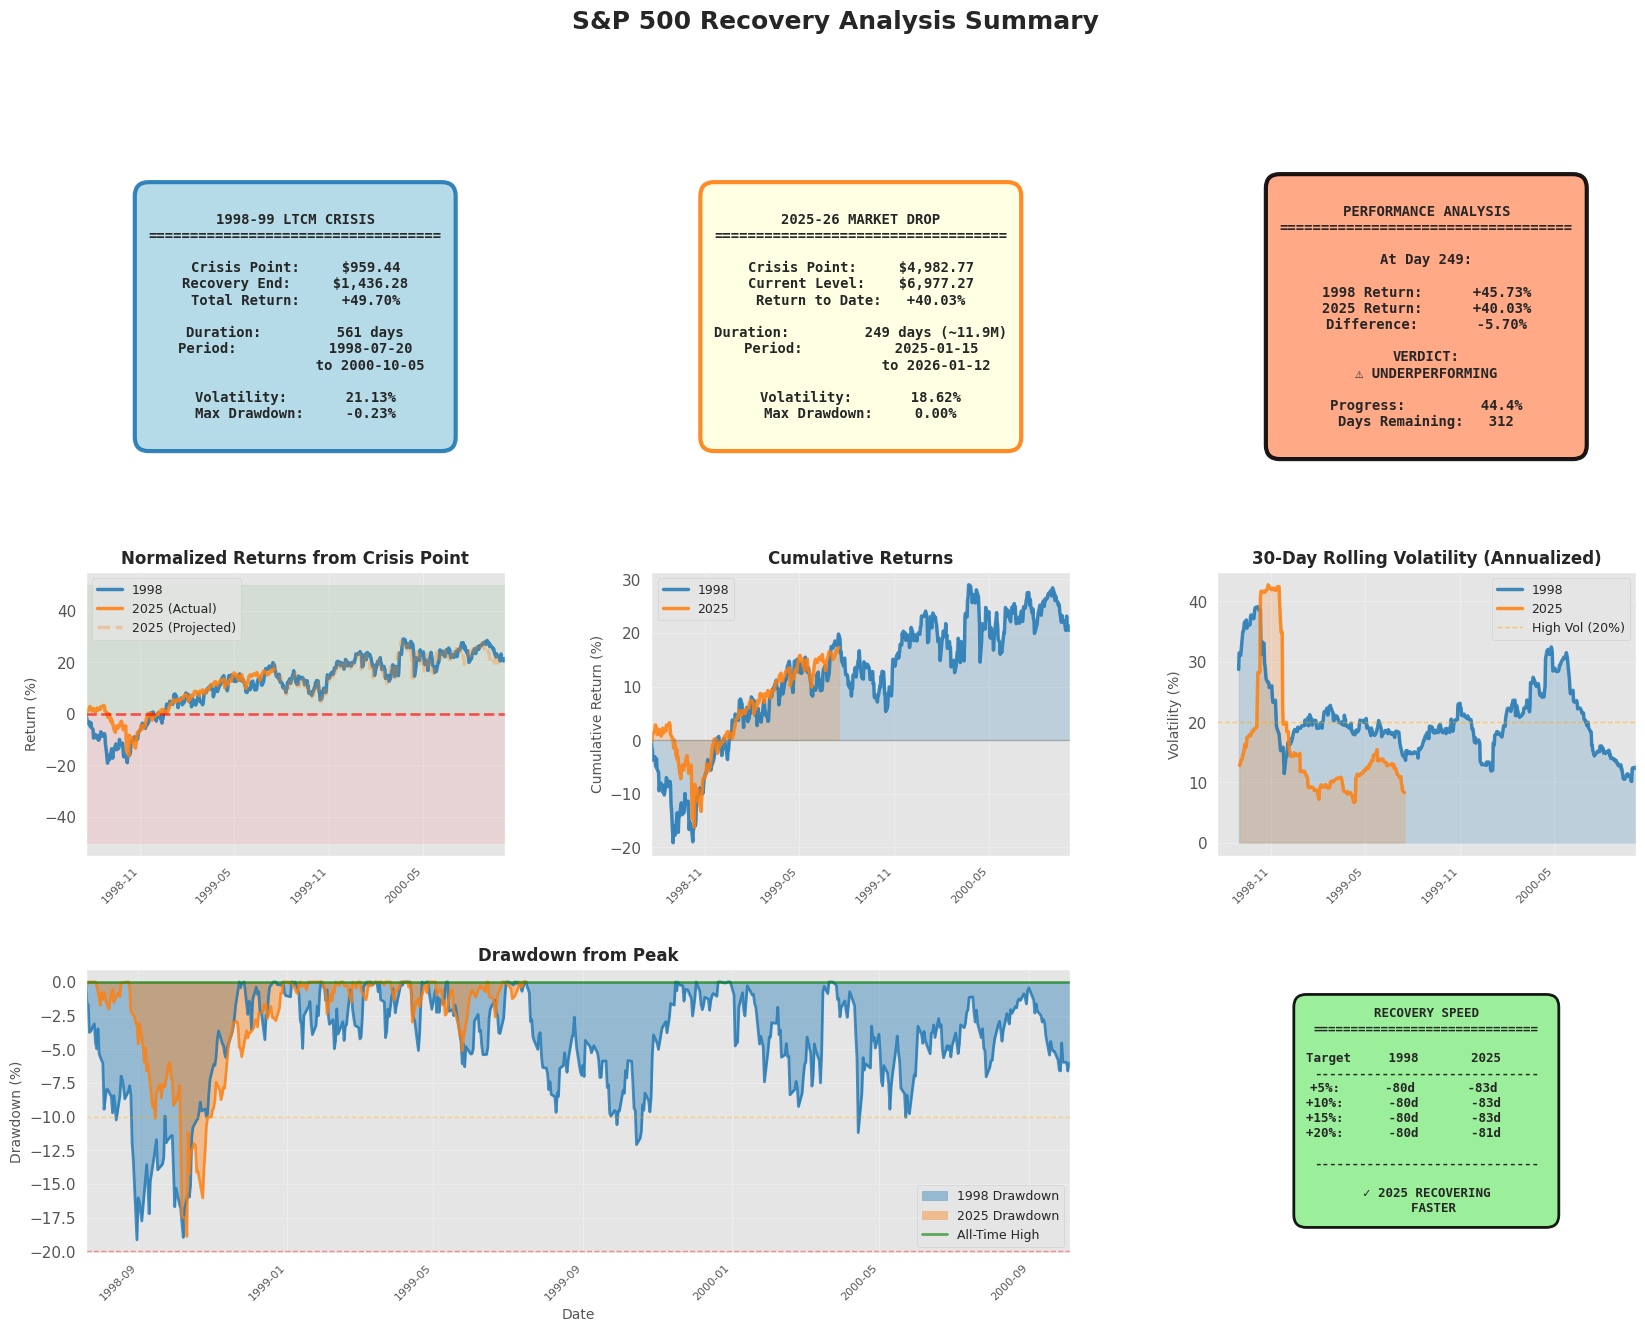

In [20]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.35)

# Calculate key metrics
crisis_price_1998 = period_1998['Close'].iloc[crisis_loc_1998]
recovery_price_1998 = period_1998['Close'].iloc[-1]
return_1998 = ((recovery_price_1998 / crisis_price_1998) - 1) * 100 if crisis_price_1998 else np.nan

if current_length > 0:
    crisis_price_2025 = period_2025_padded['Close'].iloc[crisis_loc_2025]
    current_price_2025 = period_2025_padded.loc[actual_mask_2025, 'Close'].iloc[-1]
    return_2025 = ((current_price_2025 / crisis_price_2025) - 1) * 100 if crisis_price_2025 else np.nan

    date_offset = period_1998.index[0] - period_2025_padded.index[0]
    aligned_2025_dates = period_2025_padded.index + date_offset

# 1998 Metrics Box
ax_metrics1 = fig.add_subplot(gs[0, 0])
ax_metrics1.axis('off')

metrics_1998 = f"""
1998-99 LTCM CRISIS
{'='*35}

Crisis Point:     ${crisis_price_1998:,.2f}
Recovery End:     ${recovery_price_1998:,.2f}
Total Return:     {return_1998:+.2f}%

Duration:         {len(period_1998)} days
Period:           {period_1998.index[0].strftime('%Y-%m-%d')}
                  to {period_1998.index[-1].strftime('%Y-%m-%d')}

Volatility:       {period_1998['Close'].pct_change().std() * np.sqrt(252) * 100:.2f}%
Max Drawdown:     {((period_1998['Close'].min() / crisis_price_1998) - 1) * 100:.2f}%
"""

ax_metrics1.text(
    0.5, 0.5, metrics_1998, transform=ax_metrics1.transAxes,
    fontsize=10, verticalalignment='center', horizontalalignment='center',
    fontfamily='monospace', fontweight='bold',
    bbox=dict(boxstyle='round,pad=1', facecolor='lightblue',
              edgecolor='#1f77b4', linewidth=3, alpha=0.9)
)

# 2025 Metrics Box
ax_metrics2 = fig.add_subplot(gs[0, 1])
ax_metrics2.axis('off')

if current_length > 0:
    actual_data_2025 = period_2025_padded.loc[actual_mask_2025, 'Close']
    metrics_2025 = f"""
2025-26 MARKET DROP
{'='*35}

Crisis Point:     ${crisis_price_2025:,.2f}
Current Level:    ${current_price_2025:,.2f}
Return to Date:   {return_2025:+.2f}%

Duration:         {current_length} days (~{current_length/21:.1f}M)
Period:           {period_2025_padded.index[0].strftime('%Y-%m-%d')}
                  to {period_2025_padded.index[actual_mask_2025][-1].strftime('%Y-%m-%d')}

Volatility:       {actual_data_2025.pct_change().std() * np.sqrt(252) * 100:.2f}%
Max Drawdown:     {((actual_data_2025.min() / crisis_price_2025) - 1) * 100:.2f}%
"""
    box_color = 'lightyellow'
else:
    metrics_2025 = f"""
2025-26 MARKET DROP
{'='*35}

No data available yet.
"""
    box_color = 'lightgray'

ax_metrics2.text(
    0.5, 0.5, metrics_2025, transform=ax_metrics2.transAxes,
    fontsize=10, verticalalignment='center', horizontalalignment='center',
    fontfamily='monospace', fontweight='bold',
    bbox=dict(boxstyle='round,pad=1', facecolor=box_color,
              edgecolor='#ff7f0e', linewidth=3, alpha=0.9)
)

# Performance Comparison Box
ax_comparison = fig.add_subplot(gs[0, 2])
ax_comparison.axis('off')

if current_length > 0:
    equivalent_1998_idx = min(current_length - 1, len(period_1998) - 1)
    equivalent_1998_return = ((period_1998['Close'].iloc[equivalent_1998_idx] / crisis_price_1998) - 1) * 100 if crisis_price_1998 else np.nan
    performance_diff = return_2025 - equivalent_1998_return

    if performance_diff > 2:
        verdict = "✓ OUTPERFORMING"
        verdict_color = 'lightgreen'
    elif performance_diff > 0:
        verdict = "≈ SLIGHTLY AHEAD"
        verdict_color = 'lightgreen'
    elif performance_diff > -2:
        verdict = "≈ TRACKING SIMILAR"
        verdict_color = 'lightyellow'
    else:
        verdict = "⚠ UNDERPERFORMING"
        verdict_color = 'lightsalmon'

    comparison_text = f"""
PERFORMANCE ANALYSIS
{'='*35}

At Day {current_length}:

1998 Return:      {equivalent_1998_return:+.2f}%
2025 Return:      {return_2025:+.2f}%
Difference:       {performance_diff:+.2f}%

VERDICT:
{verdict}

Progress:         {(current_length/len(period_1998))*100:.1f}%
Days Remaining:   {len(period_1998) - current_length}
"""
else:
    comparison_text = f"""
PERFORMANCE ANALYSIS
{'='*35}

Awaiting 2025 data
for comparison.
"""
    verdict_color = 'lightgray'

ax_comparison.text(
    0.5, 0.5, comparison_text, transform=ax_comparison.transAxes,
    fontsize=10, verticalalignment='center', horizontalalignment='center',
    fontfamily='monospace', fontweight='bold',
    bbox=dict(boxstyle='round,pad=1', facecolor=verdict_color,
              edgecolor='black', linewidth=3, alpha=0.9)
)

# Normalized Returns Comparison
ax_normalized = fig.add_subplot(gs[1, 0])

period_1998_norm = normalize_to_percent(period_1998['Close'])
ax_normalized.plot(period_1998.index, period_1998_norm,
                   linewidth=2.5, color='#1f77b4', label='1998', alpha=0.85)

if current_length > 0:
    period_2025_norm = normalize_to_percent(period_2025_padded['Close'])
    ax_normalized.plot(aligned_2025_dates[actual_mask_2025],
                       period_2025_norm[actual_mask_2025],
                       linewidth=2.5, color='#ff7f0e', label='2025 (Actual)', alpha=0.85)
    if current_length < target_length:
        projected_mask = ~actual_mask_2025
        ax_normalized.plot(aligned_2025_dates[projected_mask],
                           period_2025_norm[projected_mask],
                           linewidth=2.5, color='#ff7f0e', alpha=0.3,
                           linestyle='--', label='2025 (Projected)')

ax_normalized.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.6)
ax_normalized.fill_between(period_1998.index, -50, 0, alpha=0.08, color='red')
ax_normalized.fill_between(period_1998.index, 0, 50, alpha=0.08, color='green')

ax_normalized.set_title('Normalized Returns from Crisis Point', fontsize=12, fontweight='bold')
ax_normalized.set_ylabel('Return (%)', fontsize=10)
ax_normalized.legend(fontsize=9, loc='best')
ax_normalized.grid(True, alpha=0.3)
ax_normalized.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax_normalized.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax_normalized.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
ax_normalized.set_xlim(period_1998.index[0], period_1998.index[-1])

# Cumulative Returns
ax_cumulative = fig.add_subplot(gs[1, 1])

returns_1998_full = period_1998['Close'].pct_change().fillna(0)
cumulative_1998_full = (1 + returns_1998_full).cumprod() - 1

ax_cumulative.plot(period_1998.index, cumulative_1998_full * 100,
                   linewidth=2.5, color='#1f77b4', label='1998', alpha=0.85)
ax_cumulative.fill_between(period_1998.index, cumulative_1998_full * 100, 0,
                           alpha=0.2, color='#1f77b4')

if current_length > 0:
    returns_2025_full = period_2025_padded.loc[actual_mask_2025, 'Close'].pct_change().fillna(0)
    cumulative_2025_full = (1 + returns_2025_full).cumprod() - 1

    ax_cumulative.plot(aligned_2025_dates[actual_mask_2025], cumulative_2025_full * 100,
                       linewidth=2.5, color='#ff7f0e', label='2025', alpha=0.85)
    ax_cumulative.fill_between(aligned_2025_dates[actual_mask_2025], cumulative_2025_full * 100, 0,
                               alpha=0.2, color='#ff7f0e')

ax_cumulative.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
ax_cumulative.set_title('Cumulative Returns', fontsize=12, fontweight='bold')
ax_cumulative.set_ylabel('Cumulative Return (%)', fontsize=10)
ax_cumulative.legend(fontsize=9, loc='best')
ax_cumulative.grid(True, alpha=0.3)
ax_cumulative.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax_cumulative.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax_cumulative.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
ax_cumulative.set_xlim(period_1998.index[0], period_1998.index[-1])

# Volatility Analysis
ax_volatility = fig.add_subplot(gs[1, 2])

rolling_vol_1998 = period_1998['Close'].pct_change().rolling(window=30).std() * np.sqrt(252) * 100
ax_volatility.plot(period_1998.index, rolling_vol_1998,
                   linewidth=2.5, color='#1f77b4', label='1998', alpha=0.85)
ax_volatility.fill_between(period_1998.index, rolling_vol_1998, 0,
                           alpha=0.2, color='#1f77b4')

if current_length > 0 and current_length > 30:
    rolling_vol_2025 = period_2025_padded.loc[actual_mask_2025, 'Close'].pct_change().rolling(window=30).std() * np.sqrt(252) * 100
    ax_volatility.plot(aligned_2025_dates[actual_mask_2025], rolling_vol_2025,
                       linewidth=2.5, color='#ff7f0e', label='2025', alpha=0.85)
    ax_volatility.fill_between(aligned_2025_dates[actual_mask_2025], rolling_vol_2025, 0,
                               alpha=0.2, color='#ff7f0e')

ax_volatility.axhline(y=20, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='High Vol (20%)')
ax_volatility.set_title('30-Day Rolling Volatility (Annualized)', fontsize=12, fontweight='bold')
ax_volatility.set_ylabel('Volatility (%)', fontsize=10)
ax_volatility.legend(fontsize=9, loc='best')
ax_volatility.grid(True, alpha=0.3)
ax_volatility.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax_volatility.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax_volatility.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
ax_volatility.set_xlim(period_1998.index[0], period_1998.index[-1])

# Drawdown Analysis
ax_drawdown = fig.add_subplot(gs[2, :2])

running_max_1998 = period_1998['Close'].cummax()
drawdown_1998 = (period_1998['Close'] / running_max_1998 - 1) * 100

ax_drawdown.fill_between(period_1998.index, drawdown_1998, 0,
                         color='#1f77b4', alpha=0.4, label='1998 Drawdown')
ax_drawdown.plot(period_1998.index, drawdown_1998,
                 linewidth=2, color='#1f77b4', alpha=0.8)

if current_length > 0:
    running_max_2025 = period_2025_padded.loc[actual_mask_2025, 'Close'].cummax()
    drawdown_2025 = (period_2025_padded.loc[actual_mask_2025, 'Close'] / running_max_2025 - 1) * 100

    ax_drawdown.fill_between(aligned_2025_dates[actual_mask_2025], drawdown_2025, 0,
                             color='#ff7f0e', alpha=0.4, label='2025 Drawdown')
    ax_drawdown.plot(aligned_2025_dates[actual_mask_2025], drawdown_2025,
                     linewidth=2, color='#ff7f0e', alpha=0.8)

ax_drawdown.axhline(y=0, color='green', linestyle='-', linewidth=2, alpha=0.6, label='All-Time High')
ax_drawdown.axhline(y=-10, color='orange', linestyle='--', linewidth=1, alpha=0.4)
ax_drawdown.axhline(y=-20, color='red', linestyle='--', linewidth=1, alpha=0.4)

ax_drawdown.set_title('Drawdown from Peak', fontsize=12, fontweight='bold')
ax_drawdown.set_xlabel('Date', fontsize=10)
ax_drawdown.set_ylabel('Drawdown (%)', fontsize=10)
ax_drawdown.legend(fontsize=9, loc='best')
ax_drawdown.grid(True, alpha=0.3)
ax_drawdown.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax_drawdown.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.setp(ax_drawdown.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
ax_drawdown.set_xlim(period_1998.index[0], period_1998.index[-1])

ax_speed = fig.add_subplot(gs[2, 2])
ax_speed.axis('off')

if current_length > 0:
    milestones = []

    # 1998/2025 milestone comparisons
    for pct in [5, 10, 15, 20]:
        # 1998
        target_price_1998 = crisis_price_1998 * (1 + pct / 100)
        reached_1998 = period_1998[period_1998['Close'] >= target_price_1998]
        if len(reached_1998) > 0:
            days_1998 = (reached_1998.index[0] - period_1998.index[crisis_loc_1998]).days
        else:
            days_1998 = None

        # 2025 (actual only)
        target_price_2025 = crisis_price_2025 * (1 + pct / 100)
        actual_2025 = period_2025_padded.loc[actual_mask_2025]
        reached_2025 = actual_2025[actual_2025['Close'] >= target_price_2025]
        if len(reached_2025) > 0:
            days_2025 = (reached_2025.index[0] - period_2025_padded.index[crisis_loc_2025]).days
        else:
            days_2025 = None

        milestones.append((pct, days_1998, days_2025))

    speed_text = "RECOVERY SPEED\n"
    speed_text += "=" * 30 + "\n\n"
    speed_text += f"{'Target':<10} {'1998':<10} {'2025':<10}\n"
    speed_text += "-" * 30 + "\n"

    for pct, d1, d2 in milestones:
        d1998 = f"{d1}d" if d1 is not None else "N/A"
        d2025 = f"{d2}d" if d2 is not None else "N/A"
        speed_text += f"+{pct}%:{' '*6}{d1998:<10} {d2025:<10}\n"

    speed_text += "\n" + "-" * 30 + "\n"

    faster_count = sum(1 for _, d1, d2 in milestones if (d1 is not None and d2 is not None and d2 < d1))
    total_reached = sum(1 for _, d1, d2 in milestones if (d1 is not None and d2 is not None))

    if total_reached > 0:
        if faster_count > total_reached / 2:
            speed_text += "\n✓ 2025 RECOVERING\n  FASTER"
            speed_color = 'lightgreen'
        else:
            speed_text += "\n≈ SIMILAR\n  RECOVERY PACE"
            speed_color = 'lightyellow'
    else:
        speed_text += "\nInsufficient data"
        speed_color = 'lightgray'
else:
    speed_text = "RECOVERY SPEED\n"
    speed_text += "=" * 30 + "\n\n"
    speed_text += "Awaiting 2025 data\nfor analysis."
    speed_color = 'lightgray'

ax_speed.text(
    0.5, 0.5, speed_text, transform=ax_speed.transAxes,
    fontsize=9, verticalalignment='center', horizontalalignment='center',
    fontfamily='monospace', fontweight='bold',
    bbox=dict(boxstyle='round,pad=1', facecolor=speed_color,
              edgecolor='black', linewidth=2, alpha=0.9)
)

fig.suptitle('S&P 500 Recovery Analysis Summary',
             fontsize=18, fontweight='bold', y=0.998)

plt.tight_layout()
plt.show()

# Final Summary

In [21]:
print("\n" + "=" * 90)
print("ANALYSIS SUMMARY")

print("\n1. DATA COVERAGE:")
print(f"   1998 Period: {period_1998.index[0].strftime('%Y-%m-%d')} to {period_1998.index[-1].strftime('%Y-%m-%d')}")
print(f"   1998 Duration: {len(period_1998)} trading days")

if current_length > 0:
    print(f"   2025 Period: {period_2025.index[0].strftime('%Y-%m-%d')} to {period_2025.index[-1].strftime('%Y-%m-%d')}")
    print(f"   2025 Duration: {current_length} trading days (actual data)")
else:
    print(f"   2025 Period: No data available yet")

print("\n2. PRICE PERFORMANCE:")
if stats_1998[0] != "N/A":
    print(f"   1998: Started at ${stats_1998[0]:.2f}, ended at ${stats_1998[1]:.2f}")
    print(f"         Total return: {stats_1998[4]:.2f}%")
    print(f"         Max drawdown: {stats_1998[5]:.2f}%")
    print(f"         Max gain: {stats_1998[6]:.2f}%")

if current_length > 0 and stats_2025[0] != "N/A":
    print(f"   2025: Started at ${stats_2025[0]:.2f}, ended at ${stats_2025[1]:.2f}")
    print(f"         Total return: {stats_2025[4]:.2f}%")
    print(f"         Max drawdown: {stats_2025[5]:.2f}%")
    print(f"         Max gain: {stats_2025[6]:.2f}%")

print("\n3. VOLATILITY METRICS:")
if stats_1998[8] != "N/A":
    print(f"   1998: Annualized volatility = {stats_1998[8]:.2f}%")
if current_length > 0 and stats_2025[8] != "N/A":
    print(f"   2025: Annualized volatility = {stats_2025[8]:.2f}%")

print("\n4. DAILY RETURNS STATISTICS:")
if len(returns_1998) > 0:
    print(f"   1998: Mean = {returns_1998.mean():.3f}%, Std = {returns_1998.std():.3f}%")
    print(f"         Min = {returns_1998.min():.2f}%, Max = {returns_1998.max():.2f}%")
if len(returns_2025) > 0:
    print(f"   2025: Mean = {returns_2025.mean():.3f}%, Std = {returns_2025.std():.3f}%")
    print(f"         Min = {returns_2025.min():.2f}%, Max = {returns_2025.max():.2f}%")

print("\n" + "=" * 80)


ANALYSIS SUMMARY

1. DATA COVERAGE:
   1998 Period: 1998-07-20 to 2000-10-05
   1998 Duration: 561 trading days
   2025 Period: 2025-01-15 to 2026-01-12
   2025 Duration: 249 trading days (actual data)

2. PRICE PERFORMANCE:
   1998: Started at $1184.10, ended at $1436.28
         Total return: 21.30%
         Max drawdown: -19.16%
         Max gain: 29.00%
   2025: Started at $5949.91, ended at $6977.27
         Total return: 17.27%
         Max drawdown: -16.25%
         Max gain: 17.27%

3. VOLATILITY METRICS:
   1998: Annualized volatility = 21.13%
   2025: Annualized volatility = 18.62%

4. DAILY RETURNS STATISTICS:
   1998: Mean = 0.043%, Std = 1.331%
         Min = -6.80%, Max = 5.09%
   2025: Mean = 0.071%, Std = 1.173%
         Min = -5.97%, Max = 9.52%

